In [1]:
# Auto loading
%load_ext autoreload
%autoreload 2
%reload_ext autoreload

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import cPickle as pickle
import multiprocessing
import scipy.special
import numpy as np
import numpy.fft as fft
import time
import os
import sys
sys.path.insert(1,'/Users/zyzdiana/GitHub/AC297r-Volume-Registration/code')

In [3]:
import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

In [4]:
from utils import to_radian,res_to_rad,ax_to_w,rep_to_angle
from rotation_3d import tricubic_derivatives,tricubic_interp
from visualize import plot_cost_func,plot_volume,plot_slices
from cost_functions import cf_ssd
from Gauss_Newton import Gauss_Newton, axis_derivatives,print_results,sphere_mask,get_nonzero_mask,fourier_filter,get_gradient_P, window,get_mask_weights
from conversion import angles_from_q
from IRLS import Gauss_Newton_IRLS, Tukeys_Biweight

In [ ]:
oct13_dict_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_dict_10.p','rb'))
oct13_dict_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_dict_8.p','rb'))
oct13_dict_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/oct13_dict_6_4.p','rb'))

In [ ]:
# Get All Axes of Rotations
path = '/Users/zyzdiana/Dropbox/THESIS/Sept_23_navs/'
ranges = ['0_5_to_2_5','3_0_to_5_0']
files = os.listdir(path)
axes_dict = {}
for f in files[1:]:
    rot_ax = f.split('_')[2]
    trans_ax = f.split('_')[10]
    if not axes_dict.has_key(rot_ax):
        axes_dict[rot_ax] = trans_ax
print axes_dict
print axes_dict.keys()

In [5]:
jan26_dict_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/jan26_dict_10.p','rb'))
jan26_dict_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/jan26_dict_8.p','rb'))
jan26_dict_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/jan26_dict_6_4.p','rb'))

In [6]:
# Get All Axes of Rotations
path = '/Users/zyzdiana/Dropbox/THESIS/Jan_26_2016_Navs/'
ranges = ['0_5_to_2_5','3_0_to_5_0']
files = os.listdir(path)
axes_dict = {}
for f in files:
    if('open' in f):
        rot_ax = f.split('_')[3]
        trans_ax = f.split('_')[11]
    else:
        rot_ax = f.split('_')[2]
        trans_ax = f.split('_')[10]
    if not axes_dict.has_key(rot_ax):
        axes_dict[rot_ax] = trans_ax
print axes_dict

{'y': 'z', 'x': 'z', 'z': 'z'}


In [7]:
def normalize(volume):
    assert((volume >= 0).all())
    return volume * 1./np.max(volume)

Gauss-Newton method allows us to find the minimum of a least squared function through iterative procedures. Let 
$$\begin{align}
r_i(\boldsymbol{P}) = V^S(\boldsymbol{x_i}+\boldsymbol{d}(\boldsymbol{P}))-V^T
\end{align}$$

Then the iteration goes as follows,
$$\boldsymbol{P}^{s+1} = \boldsymbol{P}^{s} - \left(\mathbf{J_r}^\mathsf{T} \mathbf{J_r} \right)^{-1} \mathbf{ J_r} ^\mathsf{T} \mathbf{r}(\boldsymbol P^{s}),$$

let $w$ be weights, which is defined as $$w_i = \frac{\phi(r_i)}{r_i},$$ where
$$   \phi(r,c) = \left\{
\begin{array}{ll}
      x(1-\frac{x^2}{c^2})& |x|\leq c \\
      0 & otherwise
\end{array} 
\right. $$

Let $W = diag(w)$ then the updated Gauss_Newton iteration becomes,
$$\boldsymbol{P}^{s+1} = \boldsymbol{P}^{s} - \left(\mathbf{J_r}^\mathsf{T} \mathbf{W}\mathbf{J_r} \right)^{-1} \mathbf{ J_r} ^\mathsf{T} \mathbf{W} \mathbf{r}(\boldsymbol P^{s}),$$

In [8]:
%%time
## NORMALIZED VOLUMES
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)
rot_ax = 'z'

# Get two volumes to register
testVol1_normed = normalize(fourier_filter(jan26_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)][0],rad))
testVol2_normed = normalize(fourier_filter(jan26_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)][1],rad))
s0,s1,s2 = testVol1_normed.shape

testVol1_normed_masked = sphere_mask(testVol1_normed,rad)

vol1_normed_dervs = get_gradient_P(testVol1_normed)
vol2_normed_dervs = tricubic_derivatives(testVol2_normed)

CPU times: user 19.2 s, sys: 156 ms, total: 19.3 s
Wall time: 19.4 s


In [9]:
%%time
## NON-NORMALIZED VOLUMES
# Calculate the radius for masking
res = '8'
rad = res_to_rad(res)
rot_ax = 'y'

# Get two volumes to register
testVol1 = fourier_filter(jan26_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(0.0, 0)][0],rad)
testVol2 = fourier_filter(jan26_dict_8[rot_ax][axes_dict[rot_ax]][ranges[1]][(5.0, 0)][0],rad)
s0,s1,s2 = testVol1.shape

testVol1_masked = sphere_mask(testVol1,rad)

vol1_dervs = get_gradient_P(testVol1)
vol2_dervs = tricubic_derivatives(testVol2)

CPU times: user 19 s, sys: 110 ms, total: 19.1 s
Wall time: 19.1 s


Converged in 13 iterations!


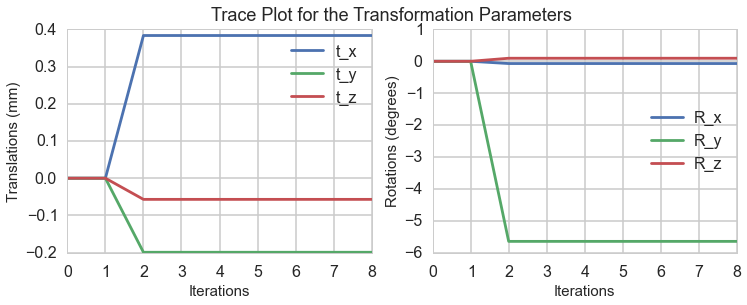

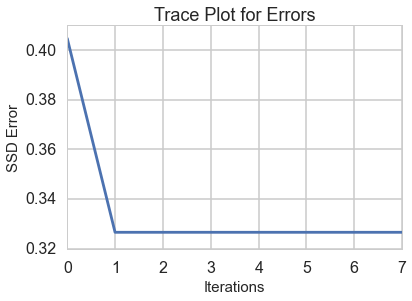

min error:  0.32657553728
parameters at min error:  [ 0.04794567 -0.0248902  -0.00711352 -0.00123518 -0.09857644  0.00166382]
translation (in mm): [ 0.38356536 -0.1991216  -0.0569082 ]
rotations (in degrees): [-0.07077057 -5.64801404  0.09532996]


In [12]:
from Gauss_Newton import Gauss_Newton1
# GN without mask
errors, Ps = Gauss_Newton1(testVol1, testVol2, vol2_dervs, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 15, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

Converged in 11 iterations!


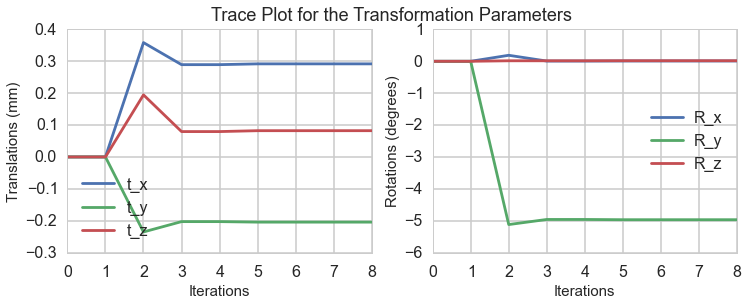

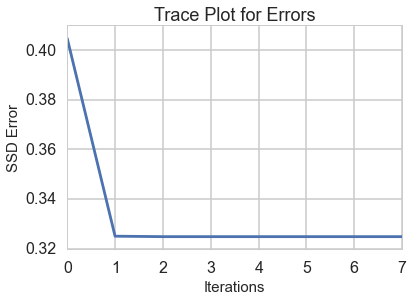

min error:  0.324816848029
parameters at min error:  [ 0.03648879 -0.02555096  0.01029325  0.00016711 -0.0867201   0.0003041 ]
translation (in mm): [ 0.2919103  -0.20440765  0.08234603]
rotations (in degrees): [ 0.00957461 -4.9686959   0.01742362]


In [11]:
# GN with mask
errors, Ps = Gauss_Newton(testVol1, vol1_dervs, testVol2, vol2_dervs, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 15, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

Converged in 12 iterations!


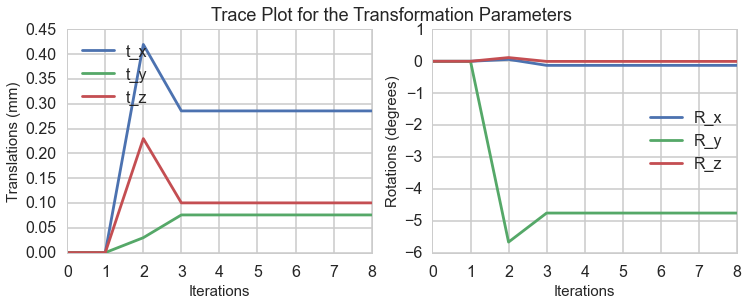

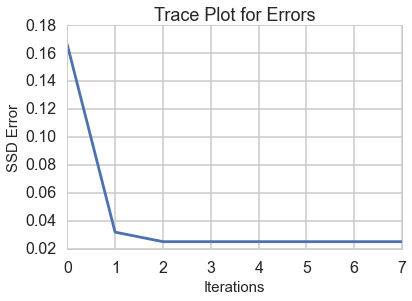

min error:  0.0249734260938
parameters at min error:  [  3.57071501e-02   9.49260082e-03   1.25287151e-02  -2.23072757e-03
  -8.30720509e-02  -6.42006737e-05]
translation (in mm): [ 0.2856572   0.07594081  0.10022972]
rotations (in degrees): [ -1.27811275e-01  -4.75967791e+00  -3.67842765e-03]


In [13]:
# GN without mask
errors, Ps = Gauss_Newton(testVol1, vol1_dervs, testVol2, vol2_dervs, mask=False, 
                          divide_factor = 1., alpha = 1., max_iter = 15, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

Converged in 3 iterations!


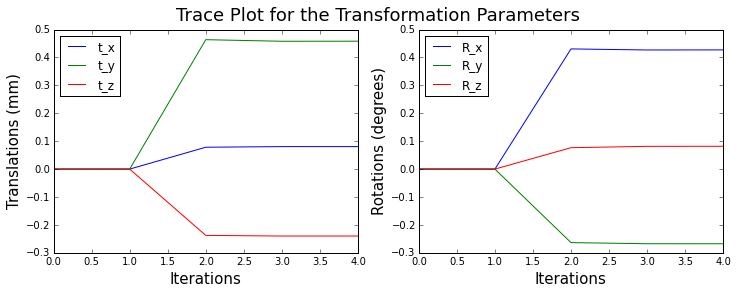

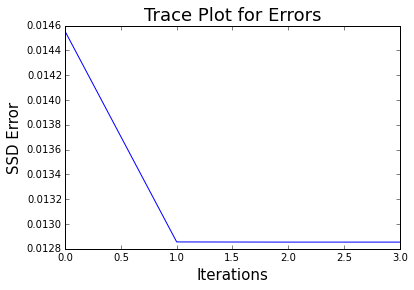

min error:  0.0128539042276
parameters at min error:  [ 0.01007225  0.05730393 -0.02998617  0.00745684 -0.00466907  0.00142749]
translation (in mm): [ 0.08057803  0.45843142 -0.23988935]
rotations (in degrees): [ 0.42724525 -0.26751802  0.08178901]


In [10]:
# GN with mask
errors, Ps = Gauss_Newton(testVol1_masked, vol1_dervs, testVol2, vol2_dervs, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 15, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

Converged in 12 iterations!


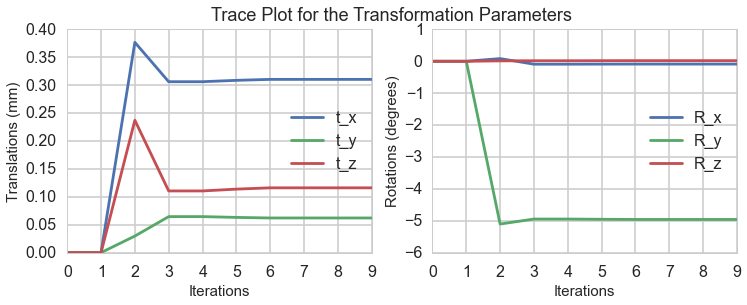

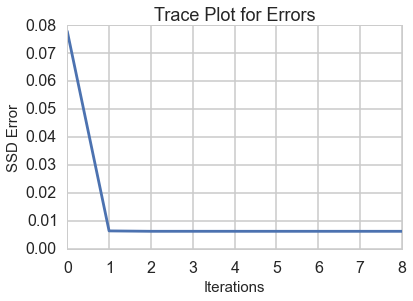

min error:  0.00620014614171
parameters at min error:  [ 0.0388031   0.00775613  0.01450972 -0.00152097 -0.08658205  0.00034958]
translation (in mm): [ 0.31042481  0.06204904  0.11607777]
rotations (in degrees): [-0.08714502 -4.96078627  0.02002956]


In [14]:
# GN with mask
errors, Ps = Gauss_Newton(testVol1_masked, vol1_dervs, testVol2, vol2_dervs, mask=True, 
                          divide_factor = 1., alpha = 1., max_iter = 15, decrease_factor = 0.25)
print_results(errors, Ps, float('.'.join(res.split('_'))))

 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 Converged in 27 iterations!


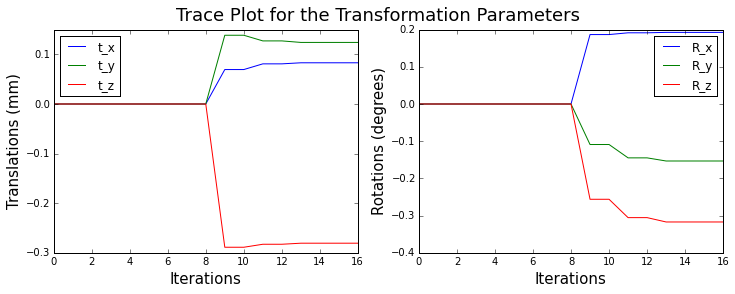

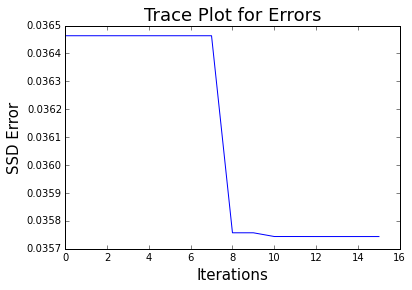

min error: 0.0357439097876
translations: [ 0.08309229  0.1241436  -0.28064194] rotations: [ 0.19250696 -0.15321747 -0.31713483]
CPU times: user 1min 40s, sys: 1min 41s, total: 3min 22s
Wall time: 1min 31s


In [12]:
%%time
## IRLS Without mask
w = np.eye(s0*s1*s2)
P, R, error,error2 = Gauss_Newton_IRLS(testVol1, vol1_dervs, testVol2, vol2_dervs, w,
                         d=0.4, c=6, divide_factor = 1., alpha = 1., decrease_factor = 0.25, 
                         max_iter = 40, mask = False, plot_mask = False)
print 'translations:', P[-1][:3]*8., 'rotations:',P[-1][3:]*180/np.pi

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 Converged in 17 iterations!


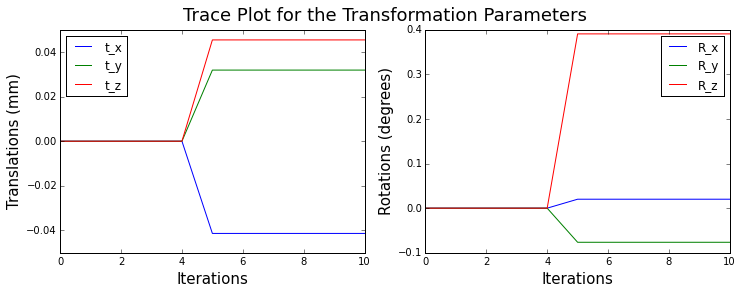

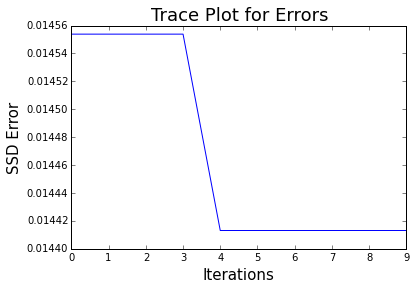

min error: 0.0144131178396
translations: [-0.04132091  0.03186129  0.04537691] rotations: [ 0.02003718 -0.07641879  0.39038908]
CPU times: user 1min 2s, sys: 1min 2s, total: 2min 4s
Wall time: 52.9 s


In [13]:
%%time
## IRLS with mask
w = np.eye(s0*s1*s2)
P, R, error,error2 = Gauss_Newton_IRLS(testVol1_masked, vol1_dervs, testVol2, vol2_dervs, w,
                         d=0.4, c=6, divide_factor = 1., alpha = 1., decrease_factor = 0.25, 
                         max_iter = 20, mask = True, plot_mask = False)
print 'translations:', P[-1][:3]*8., 'rotations:',P[-1][3:]*180/np.pi

# Find optimal c

In [ ]:
%%time

c_errors = []
c_errors.append(error)
c_ls = np.arange(0,0.01,0.0005)[1:]
for c in c_ls:
    print 'c = ', c
    w = Tukeys_Biweight(R,c)
    W = np.diag(w)
    P_new, R_new, err = Gauss_Newton_IRLS(testVol1_masked, vol1_dervs, testVol2, vol2_dervs, W,
                             divide_factor = 16., alpha = 1., decrease_factor = 0.25, 
                             P_initial = P, max_iter = 15, mask = True)
    c_errors.append(err)
    print 'translations:', P_new[:3]*8, 'rotations:',P_new[3:]*180/np.pi

In [ ]:
c_ls = np.arange(0,0.01,0.0005)[1:]
plt.plot(c_ls, c_errors[1:])
plt.hlines(c_errors[0],0,0.01,'red',label='original ssd')
plt.xlabel('values of c')
plt.ylabel('SSD')
plt.legend(loc='best')
plt.show()

In [ ]:
%%time
c_errors = []
c_errors.append(error)
for c in xrange(1,100):
    print 'c = ', c
    w = Tukeys_Biweight(R,c)
    W = np.diag(w)
    P_new, R_new, err = Gauss_Newton_IRLS(testVol1_masked, vol1_dervs, testVol2, vol2_dervs, W,
                             divide_factor = 16., alpha = 1., decrease_factor = 0.25, 
                             P_initial = P, max_iter = 15, mask = True)
    c_errors.append(err)
    print 'translations:', P_new[:3]*8, 'rotations:',P_new[3:]*180/np.pi

In [ ]:
c_ls = np.arange(1,100)
plt.plot(c_ls, c_errors[1:])
plt.hlines(c_errors[0],0,100,'red',label='original ssd')
plt.xlabel('values of c')
plt.ylabel('SSD')
plt.legend(loc='best')
plt.show()

# Plot Result from Registering open-close

In [27]:
cost_dict_6_4 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/jan26_IRLS_open_close_6_4.p','rb'))
cost_dict_8 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/jan26_IRLS_open_close_8.p','rb'))
cost_dict_10 = pickle.load(open('/Users/zyzdiana/Dropbox/THESIS/Pickled_Results/jan26_IRLS_open_close_10.p','rb'))

In [16]:
def get_residuals_IRLS(error_ls):
    residuals = []
    for errors in error_ls:
        residuals.append(errors[-1])
    return residuals

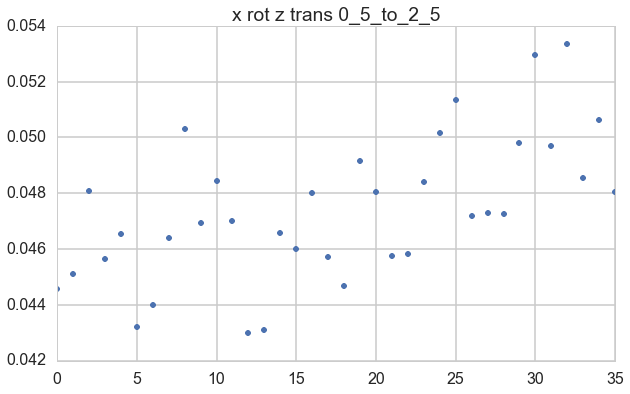

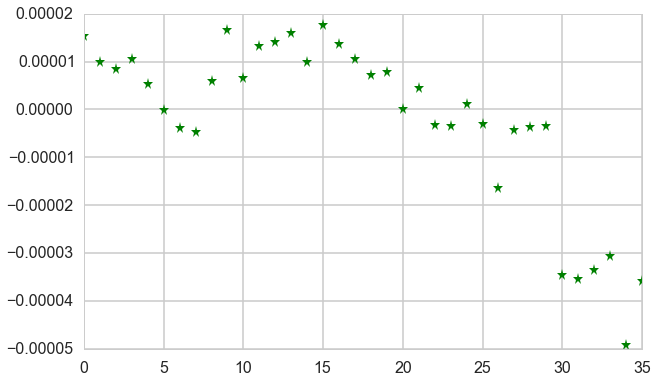

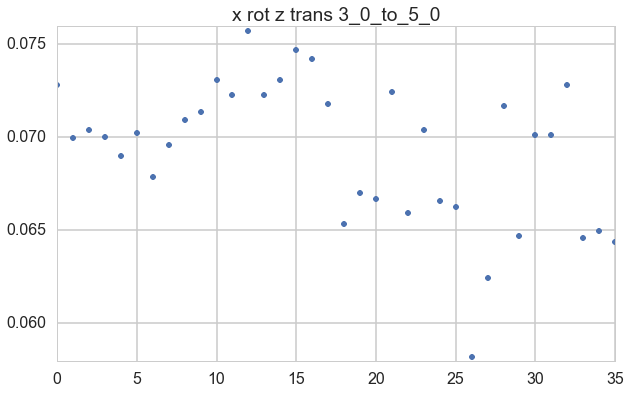

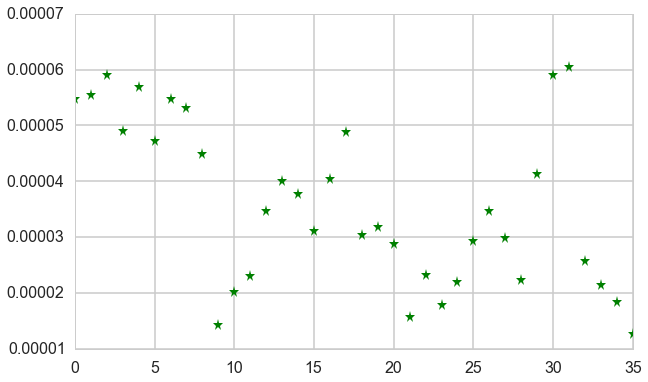

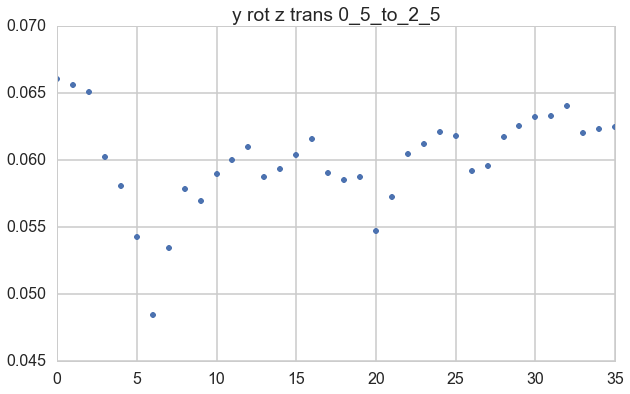

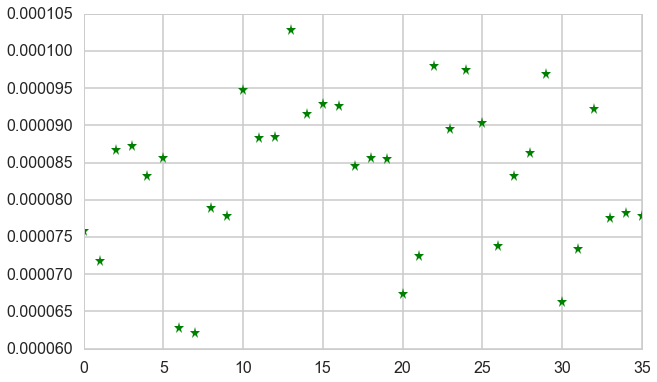

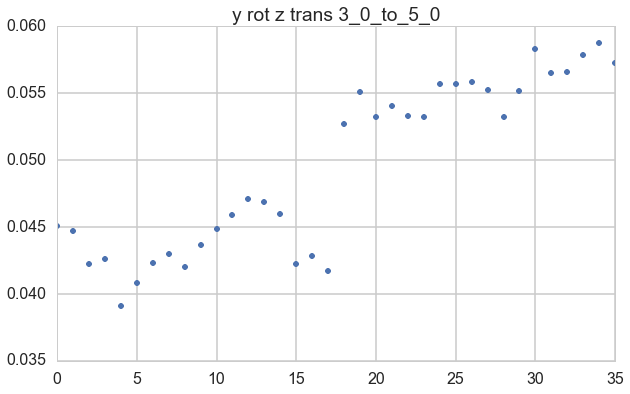

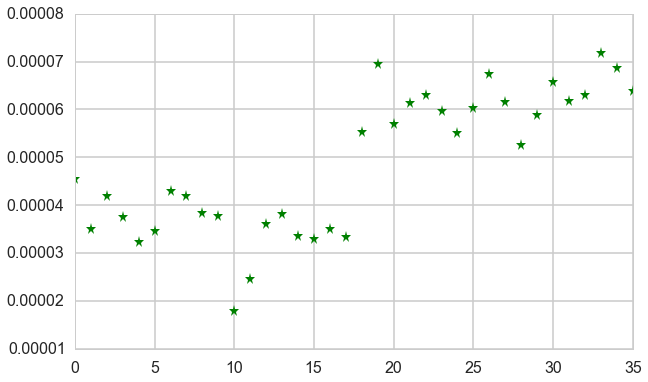

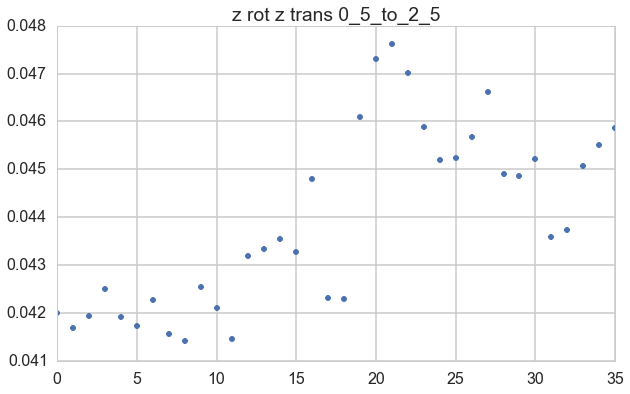

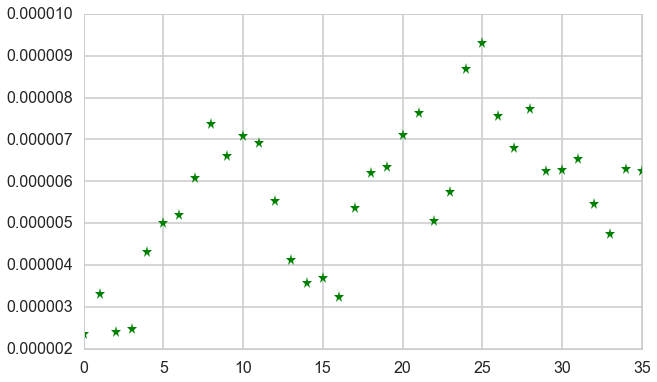

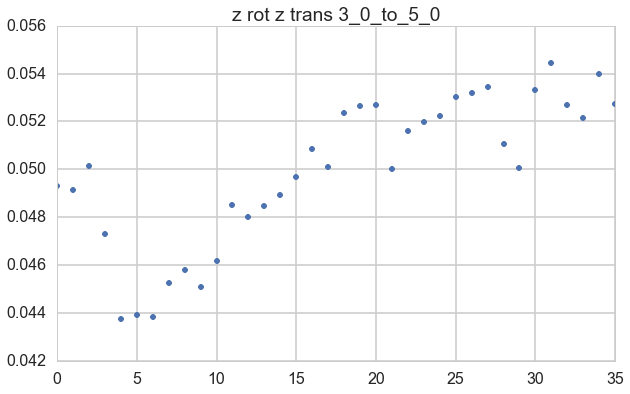

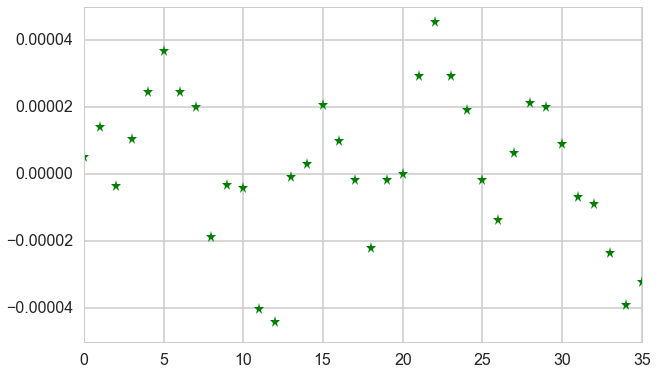

In [35]:
# plot results from 6.4mm
for i, rot_ax in enumerate(['x','y','z']):
    trans_ax = axes_dict[rot_ax]
    
    idx = 0
    residuals_6_4 = get_residuals_IRLS(cost_dict_6_4[i][2])
    e2_6_4 =  get_residuals_IRLS(cost_dict_6_4[i][3])
    
    for rot_range in ranges:
        errors_to_plot = []
        e2_to_plot = []
        for rep in xrange(36):
            errors_to_plot.append(residuals_6_4[idx])
            e2_to_plot.append(e2_6_4[idx])
            idx += 1
        plt.figure(figsize=[10,6])
        plt.plot(errors_to_plot,'.')
        plt.title("%s rot %s trans %s" % (rot_ax, trans_ax, rot_range))
        plt.show()
        plt.figure(figsize=[10,6])
        plt.plot(e2_to_plot,'*',color='green')
        plt.show()

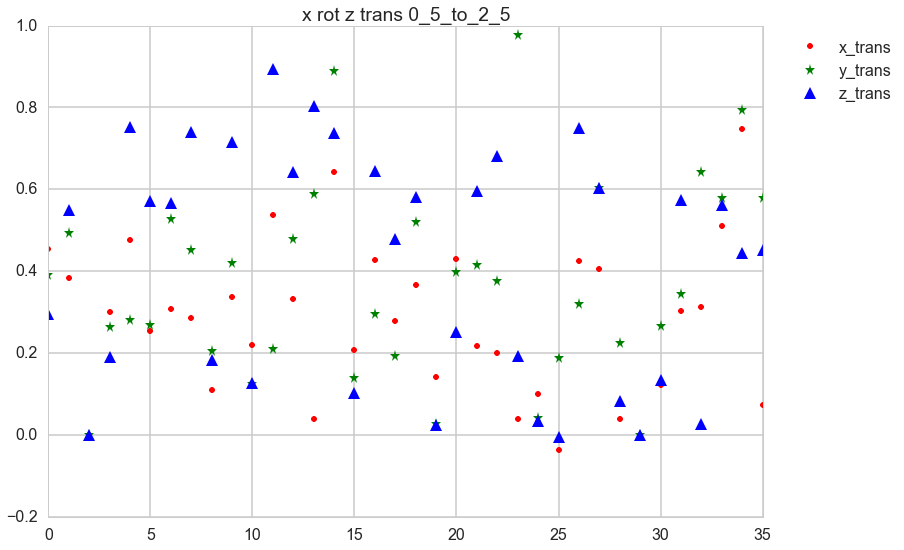

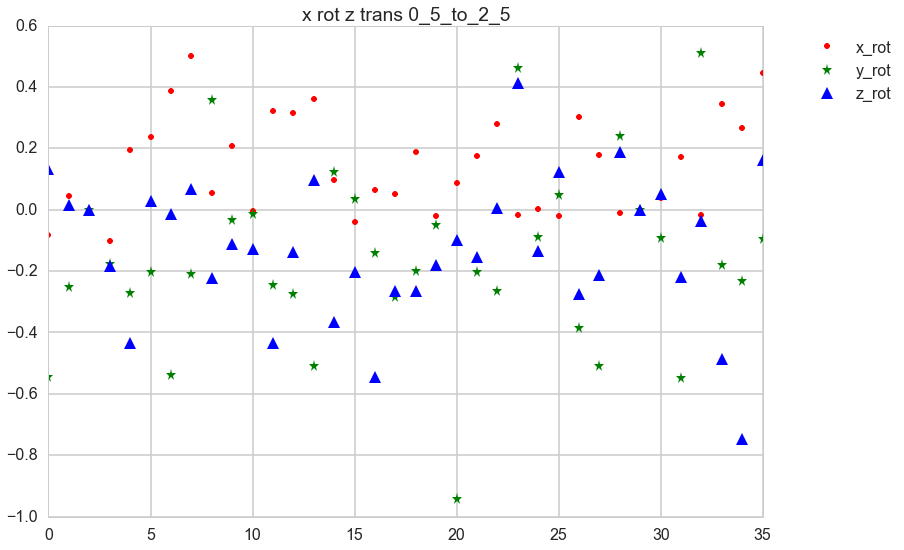

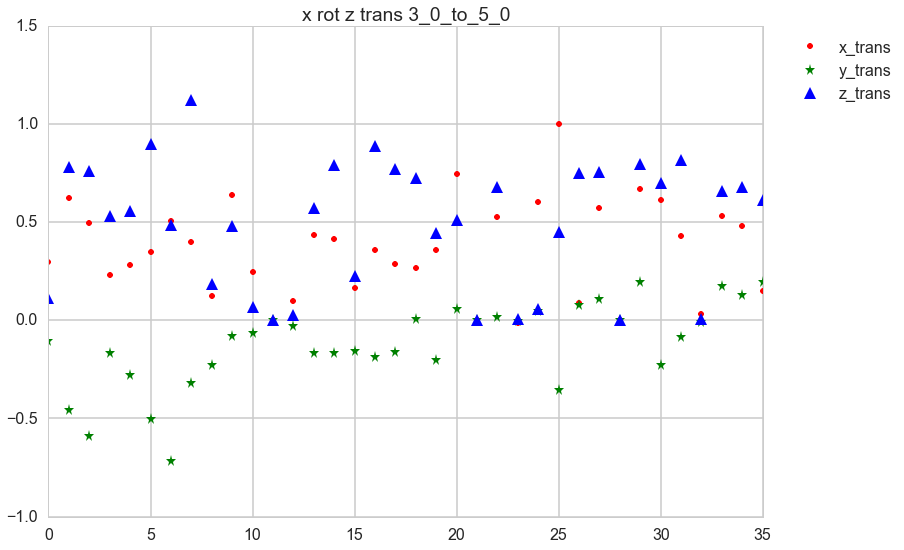

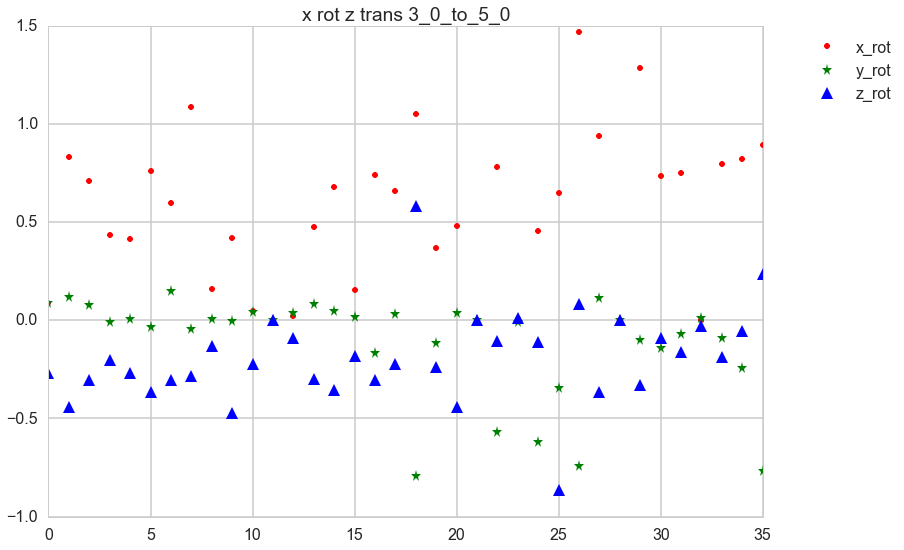

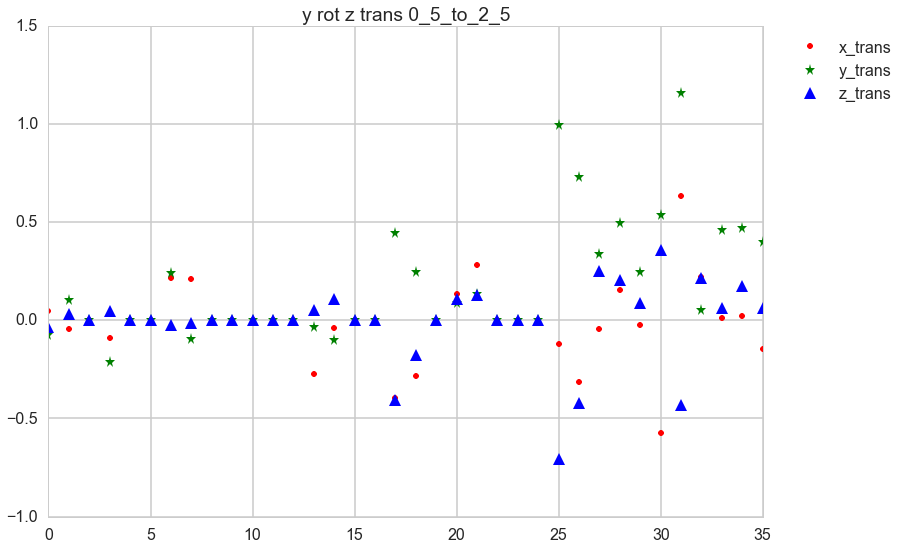

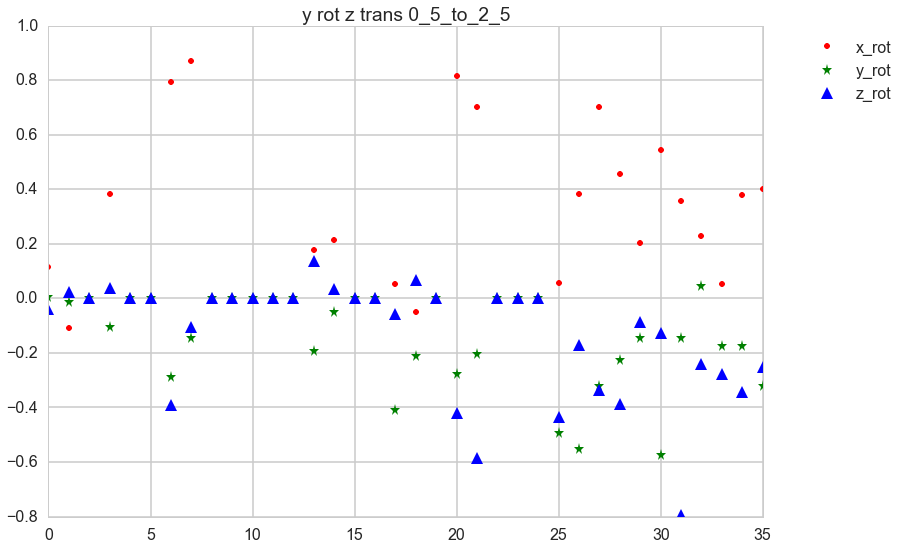

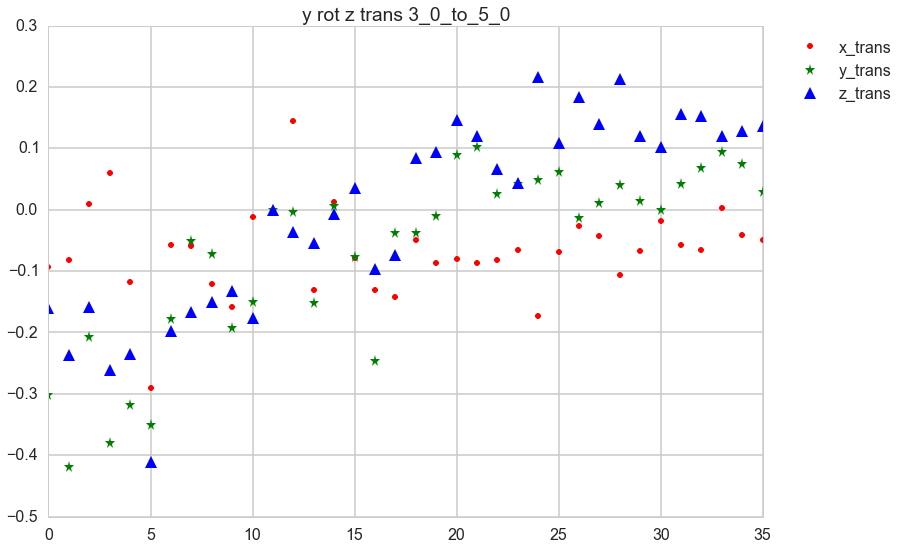

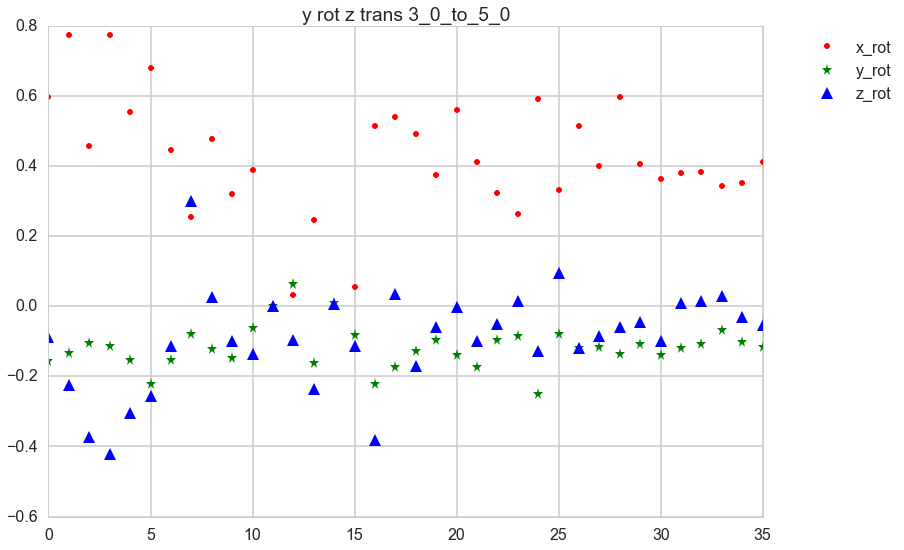

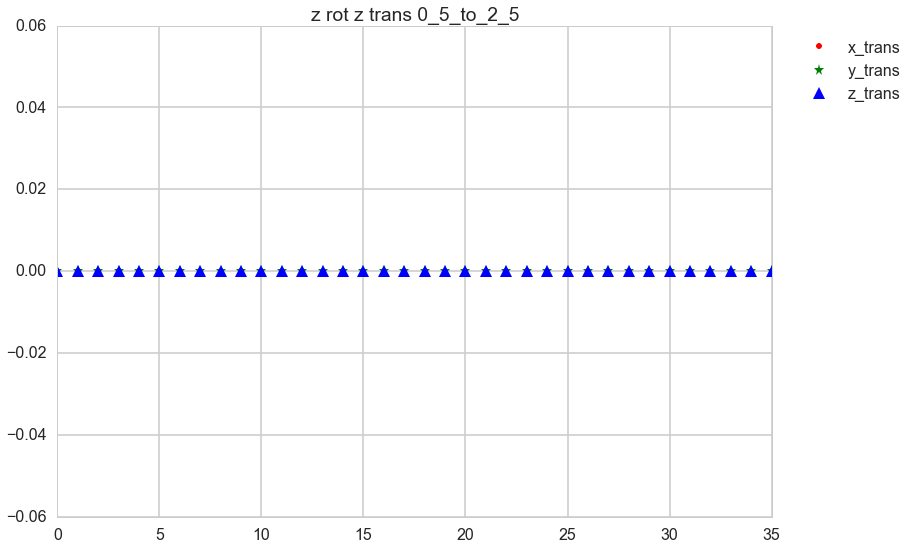

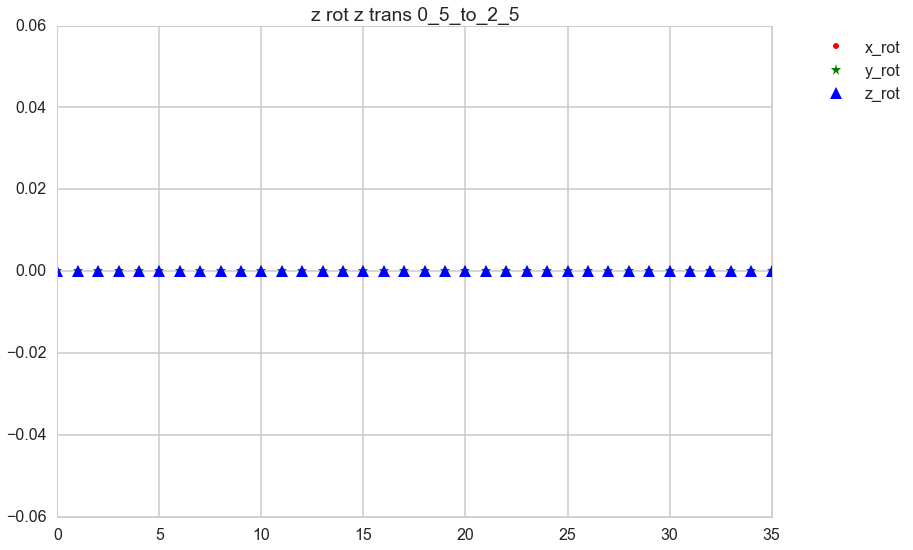

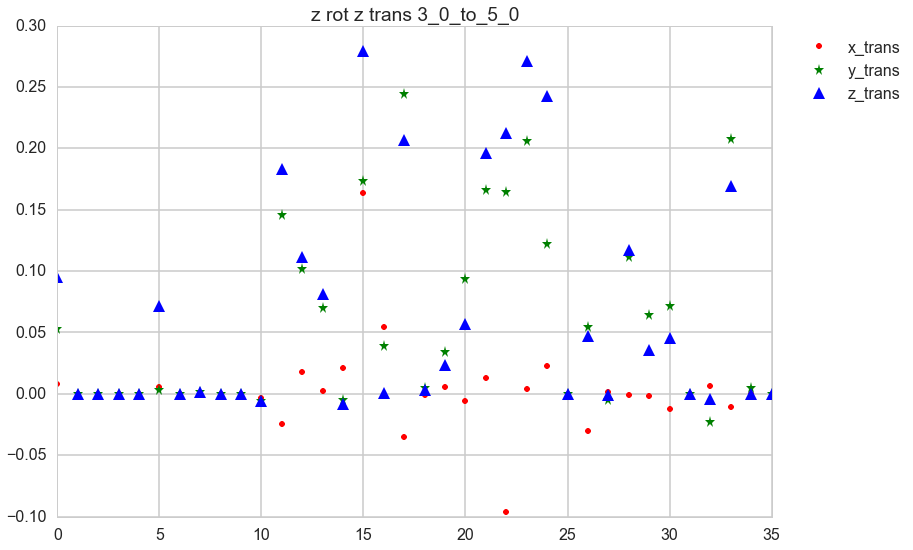

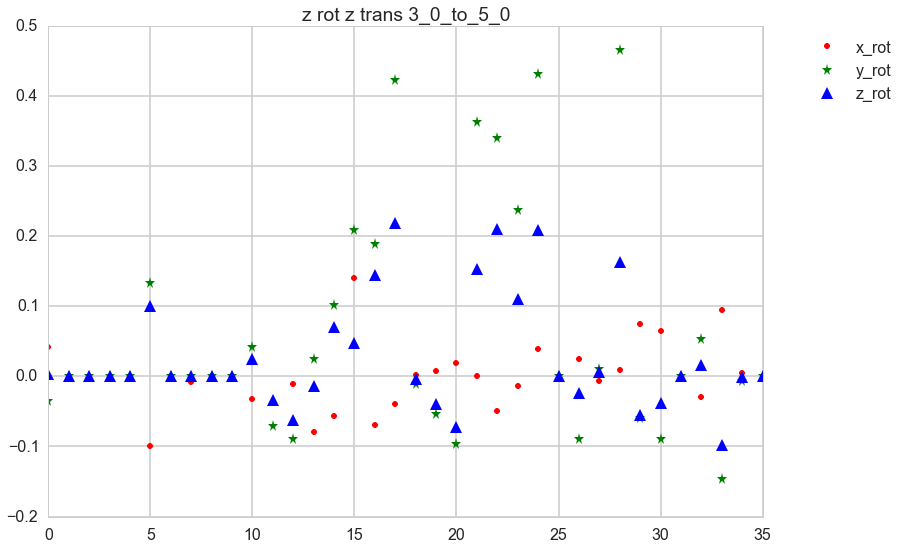

In [29]:
for i, rot_ax in enumerate(['x','y','z']):
    idx = 0
    trans_ax = axes_dict[rot_ax]
    ps_ls_6_4 = cost_dict_6_4[i][0]
    for rot_range in ranges:
        params_t = []
        params_r = []
        for rep in xrange(36):
            params_t.append(ps_ls_6_4[idx][-1][:3]*6.4)
            params_r.append(ps_ls_6_4[idx][-1][3:]*180/np.pi)
            idx += 1
        plt.plot(np.array(params_t)[:,0],'.',color='red',label='x_trans')
        plt.plot(np.array(params_t)[:,1],'*',color='green',label='y_trans')
        plt.plot(np.array(params_t)[:,2],'^',color='blue',label='z_trans')
        plt.title("%s rot %s trans %s" % (rot_ax, trans_ax, rot_range))
        plt.legend(bbox_to_anchor=(1.2, 1))
        plt.show()
        
        plt.plot(np.array(params_r)[:,0],'.',color='red',label='x_rot')
        plt.plot(np.array(params_r)[:,1],'*',color='green',label='y_rot')
        plt.plot(np.array(params_r)[:,2],'^',color='blue',label='z_rot')
        plt.title("%s rot %s trans %s" % (rot_ax, trans_ax, rot_range))
        plt.legend(bbox_to_anchor=(1.2, 1))
        plt.show()

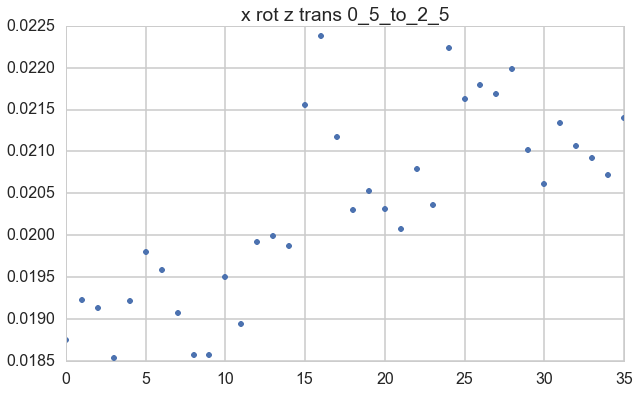

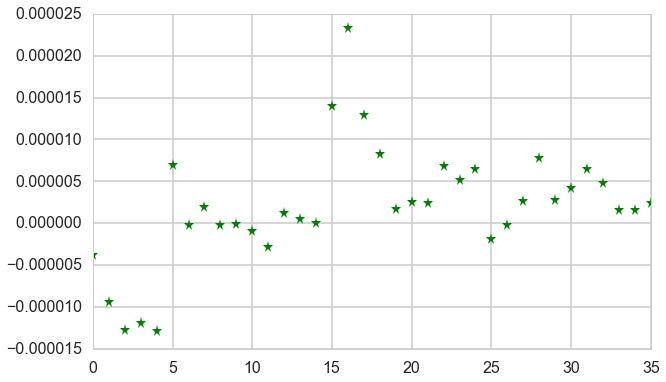

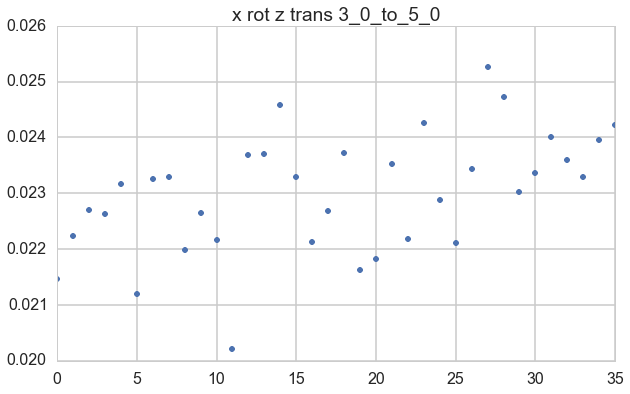

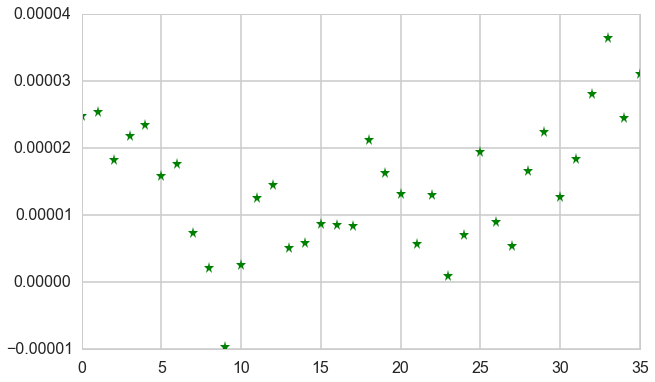

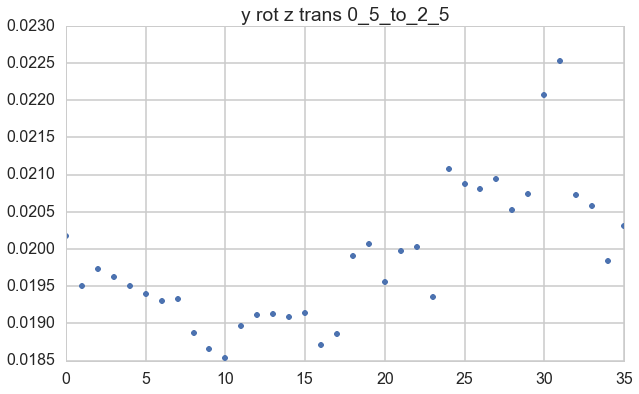

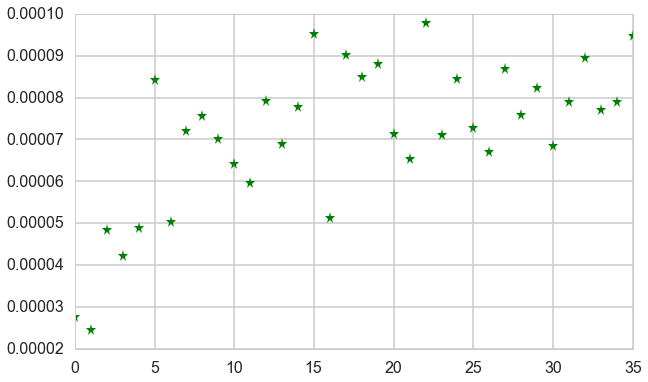

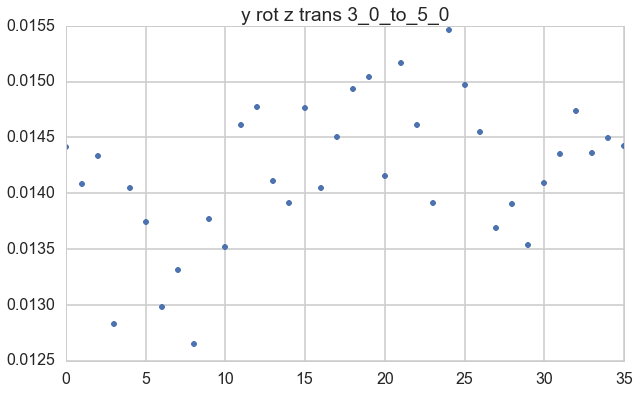

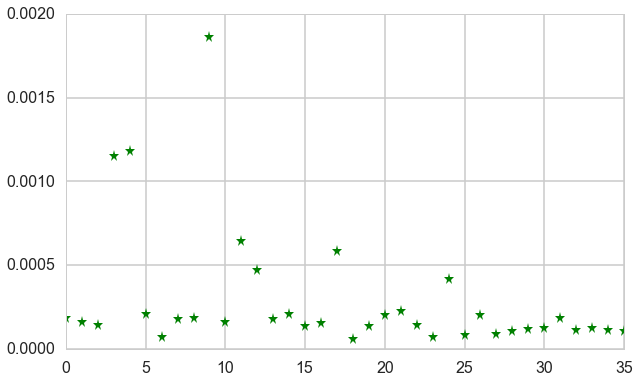

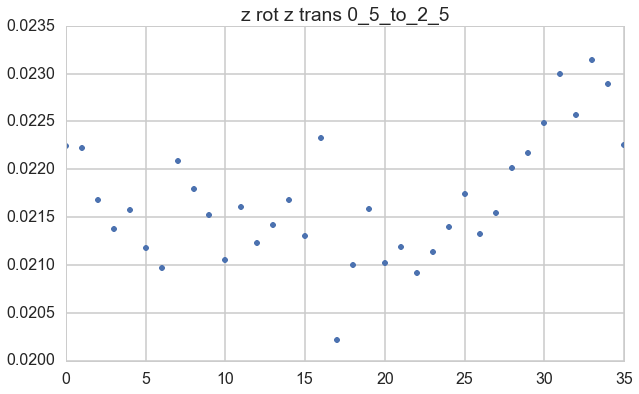

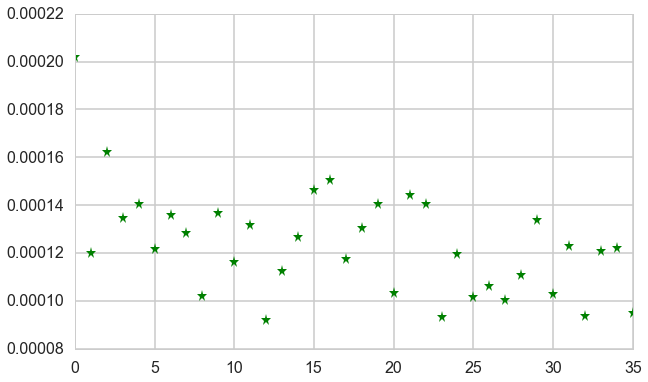

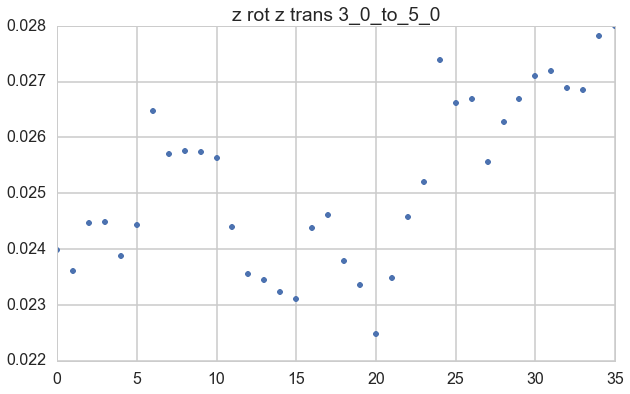

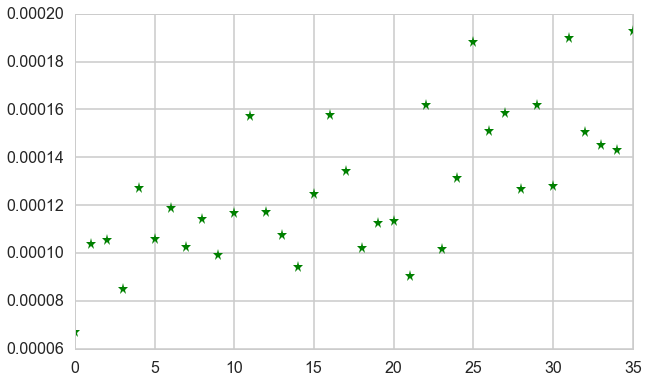

In [36]:
# plot results from 8mm
for i, rot_ax in enumerate(['x','y','z']):
    trans_ax = axes_dict[rot_ax]
    
    idx = 0
    residuals_8 = get_residuals_IRLS(cost_dict_8[i][2])
    e2_8 =  get_residuals_IRLS(cost_dict_8[i][3])
    
    for rot_range in ranges:
        errors_to_plot = []
        e2_to_plot = []
        for rep in xrange(36):
            errors_to_plot.append(residuals_8[idx])
            e2_to_plot.append(e2_8[idx])
            idx += 1
        plt.figure(figsize=[10,6])
        plt.plot(errors_to_plot,'.')
        plt.title("%s rot %s trans %s" % (rot_ax, trans_ax, rot_range))
        plt.show()
        plt.figure(figsize=[10,6])
        plt.plot(e2_to_plot,'*',color='green')
        plt.show()

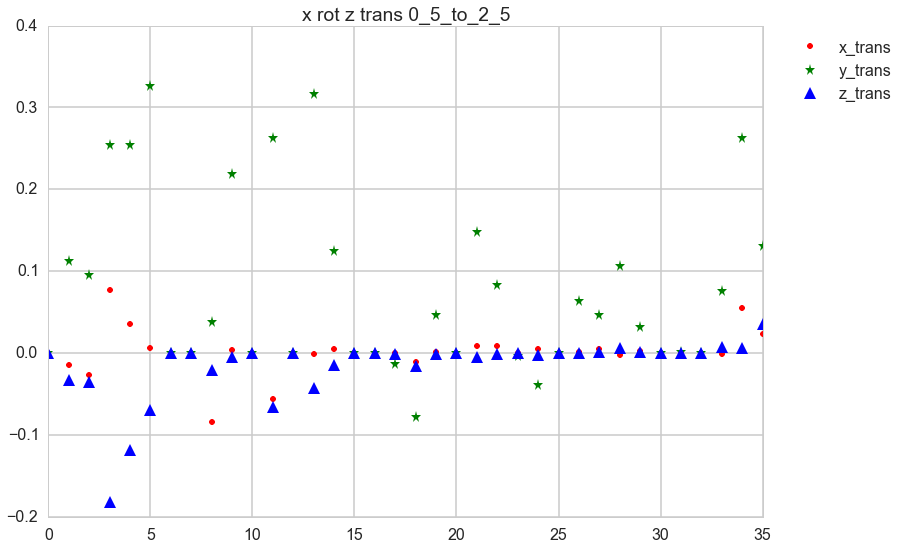

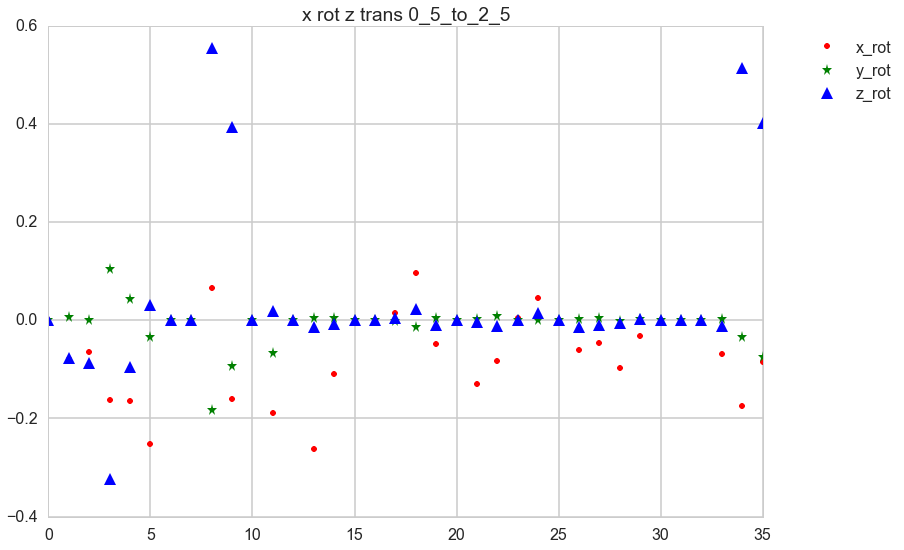

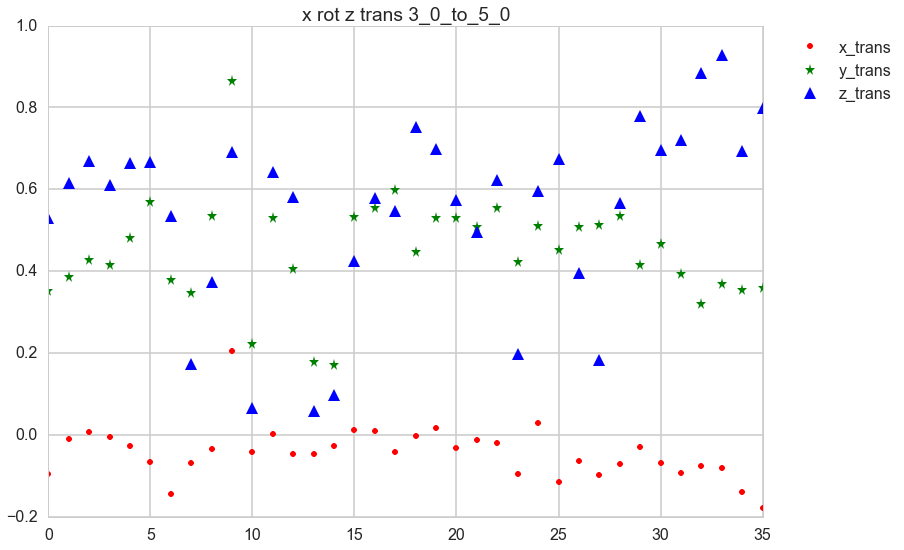

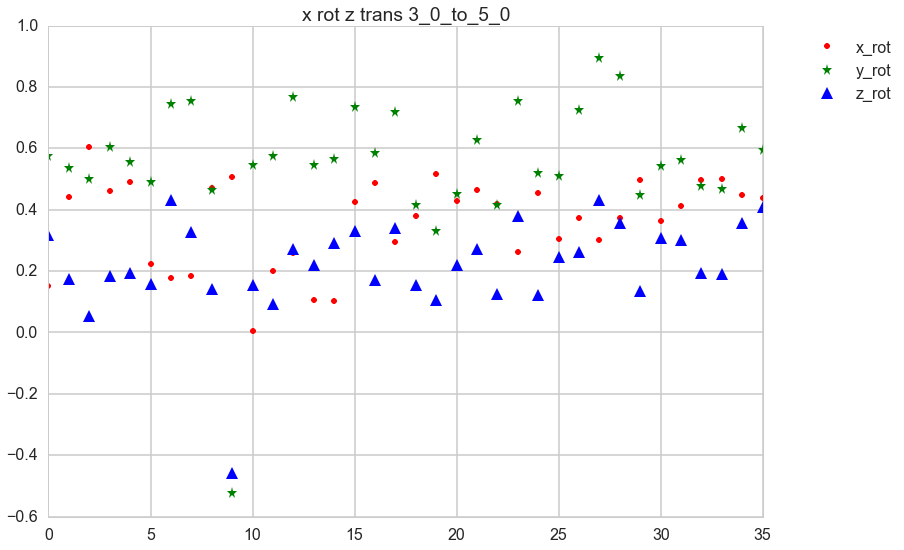

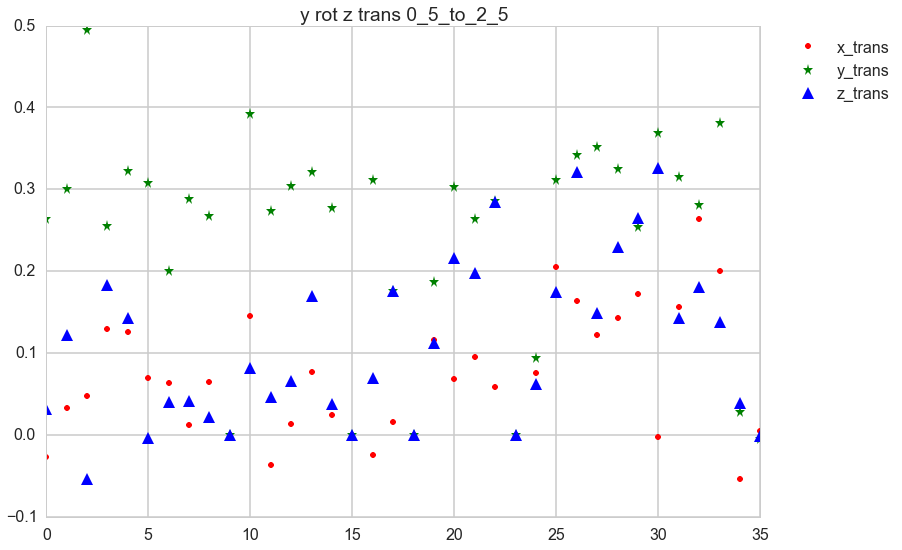

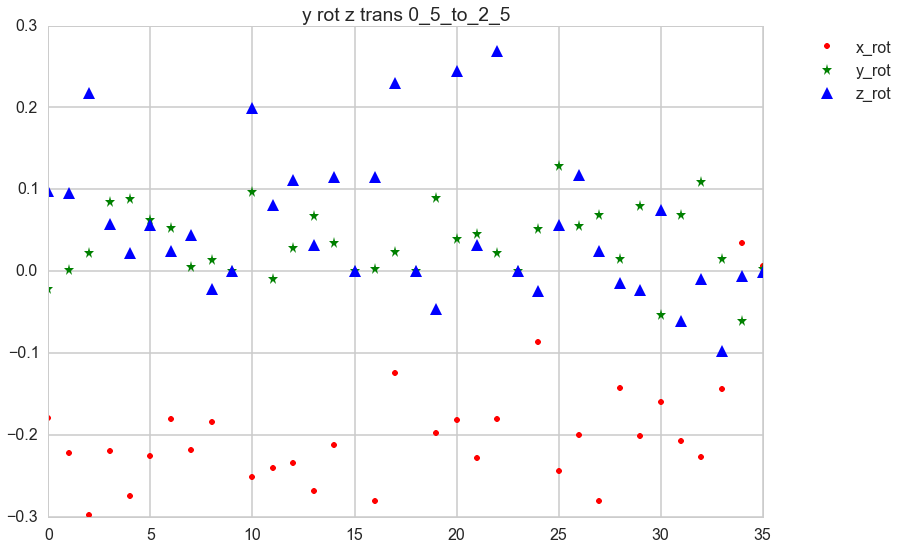

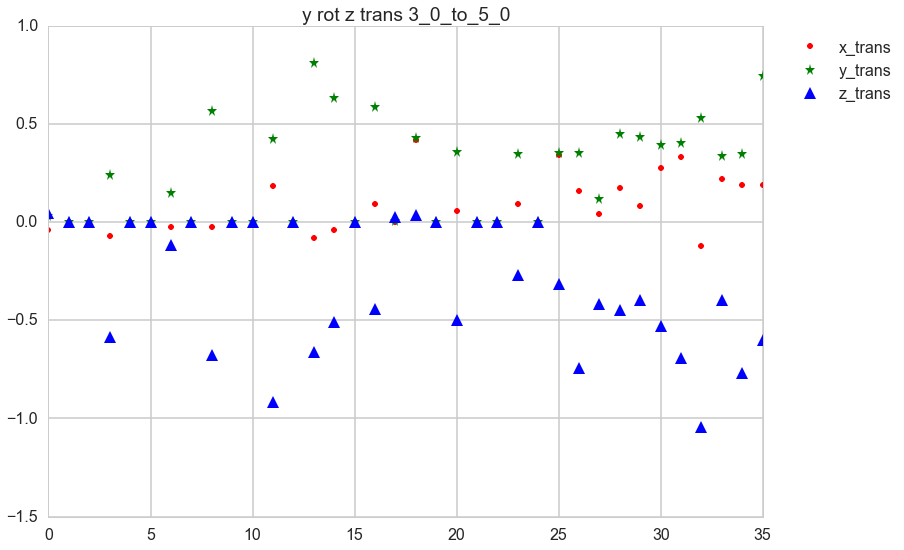

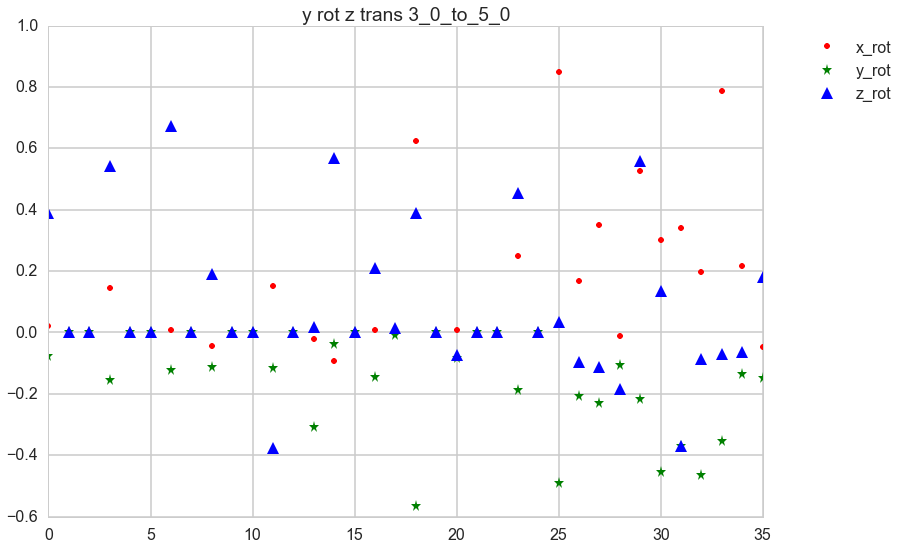

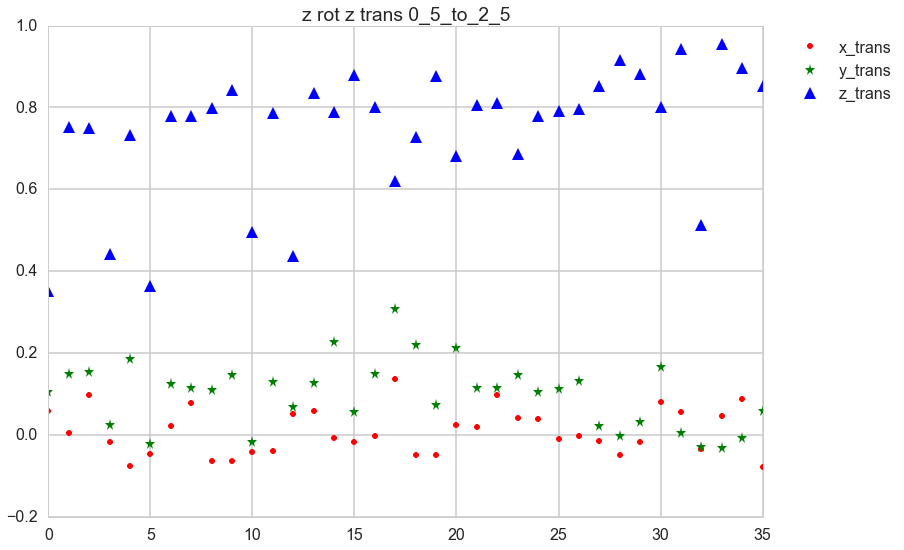

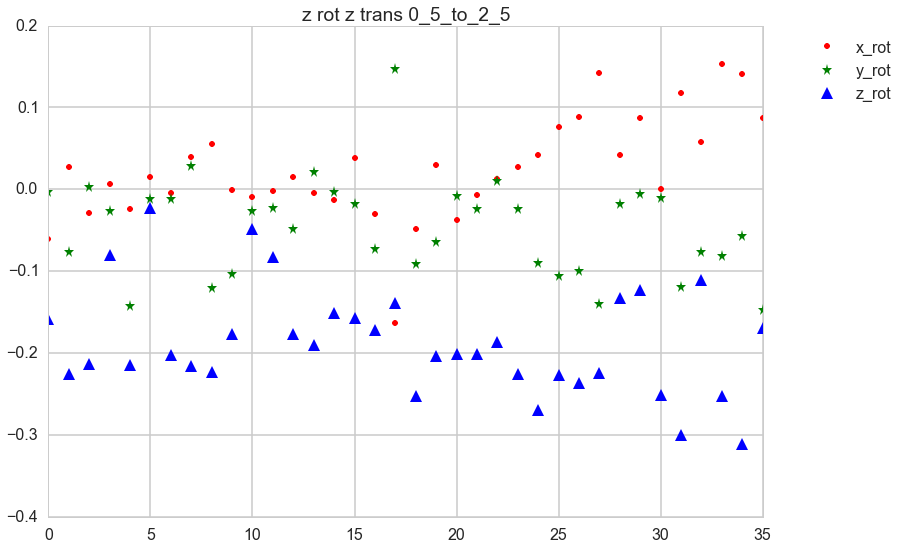

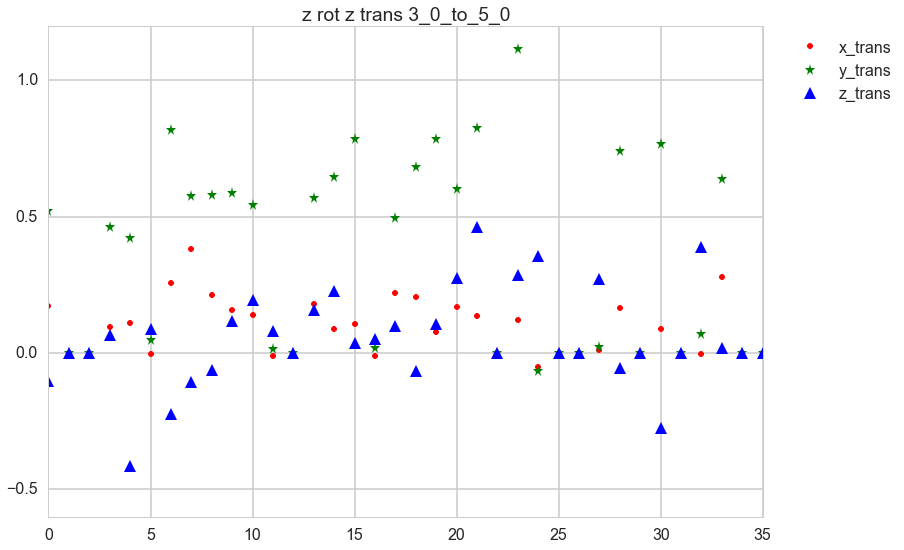

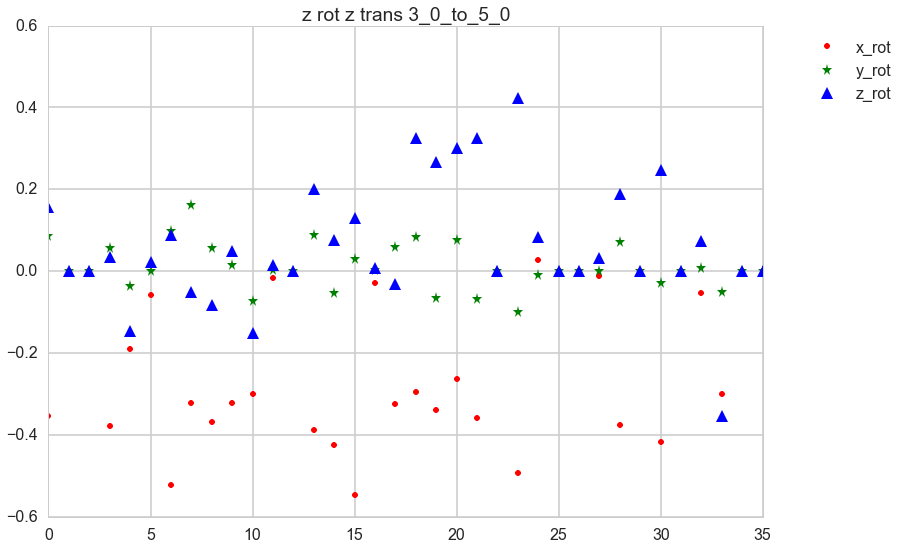

In [22]:
for i, rot_ax in enumerate(['x','y','z']):
    idx = 0
    trans_ax = axes_dict[rot_ax]
    ps_ls_8 = cost_dict_8[i][0]
    for rot_range in ranges:
        params_t = []
        params_r = []
        for rep in xrange(36):
            params_t.append(ps_ls_8[idx][-1][:3]*8)
            params_r.append(ps_ls_8[idx][-1][3:]*180/np.pi)
            idx += 1
        plt.plot(np.array(params_t)[:,0],'.',color='red',label='x_trans')
        plt.plot(np.array(params_t)[:,1],'*',color='green',label='y_trans')
        plt.plot(np.array(params_t)[:,2],'^',color='blue',label='z_trans')
        plt.title("%s rot %s trans %s" % (rot_ax, trans_ax, rot_range))
        plt.legend(bbox_to_anchor=(1.2, 1))
        plt.show()
        
        plt.plot(np.array(params_r)[:,0],'.',color='red',label='x_rot')
        plt.plot(np.array(params_r)[:,1],'*',color='green',label='y_rot')
        plt.plot(np.array(params_r)[:,2],'^',color='blue',label='z_rot')
        plt.title("%s rot %s trans %s" % (rot_ax, trans_ax, rot_range))
        plt.legend(bbox_to_anchor=(1.2, 1))
        plt.show()

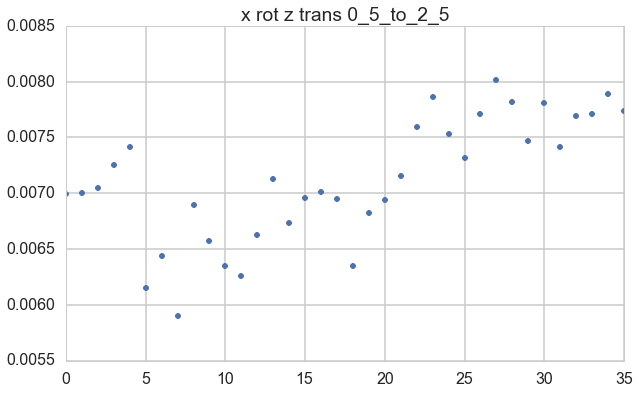

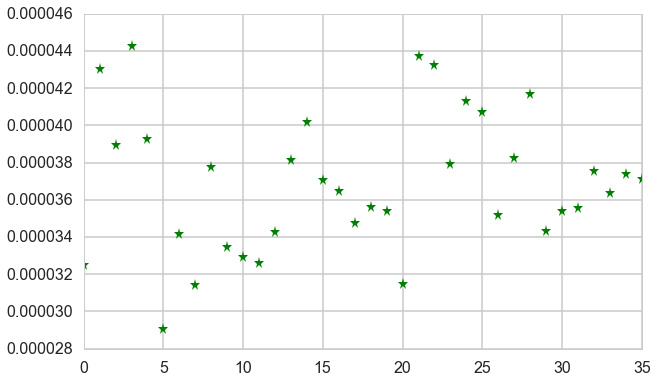

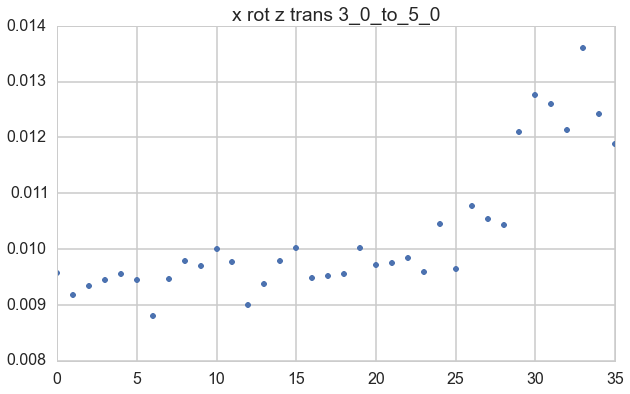

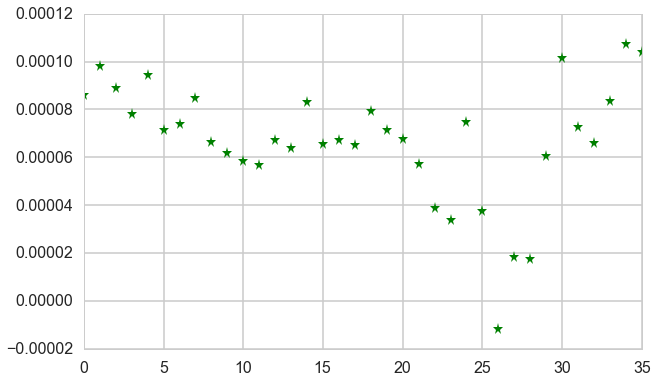

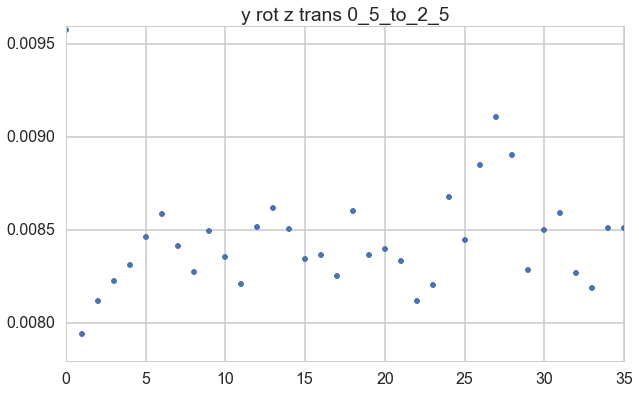

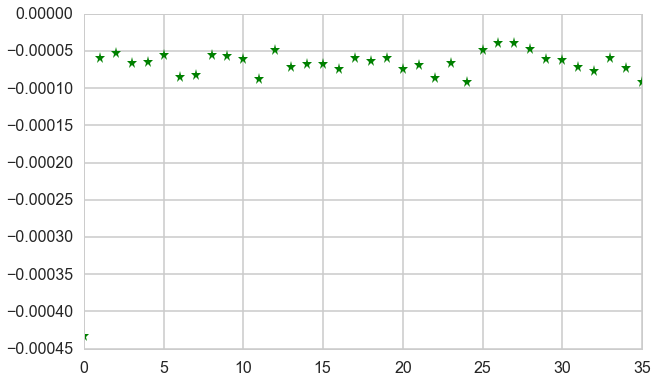

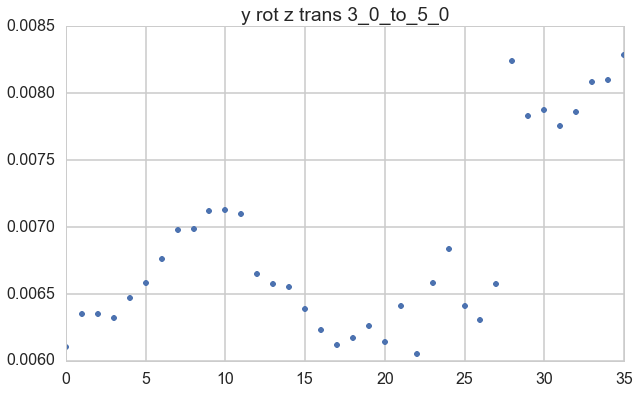

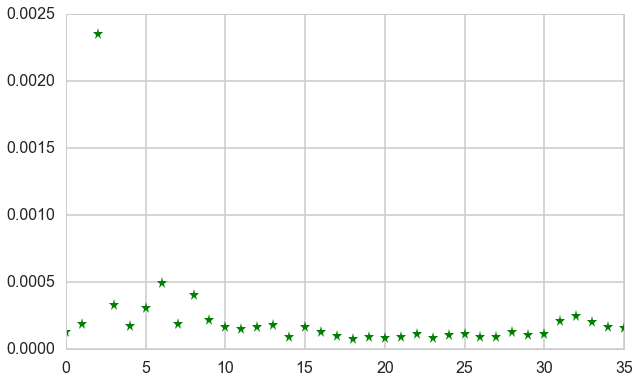

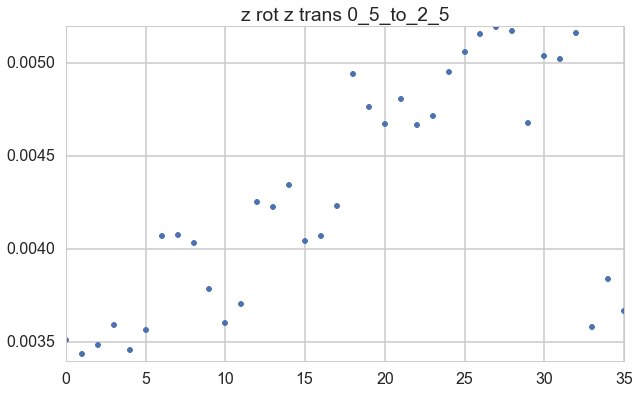

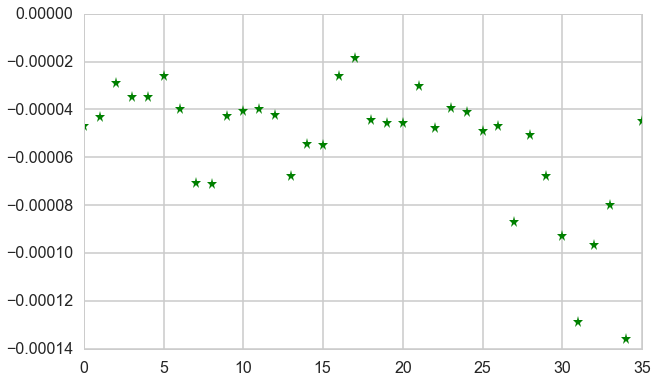

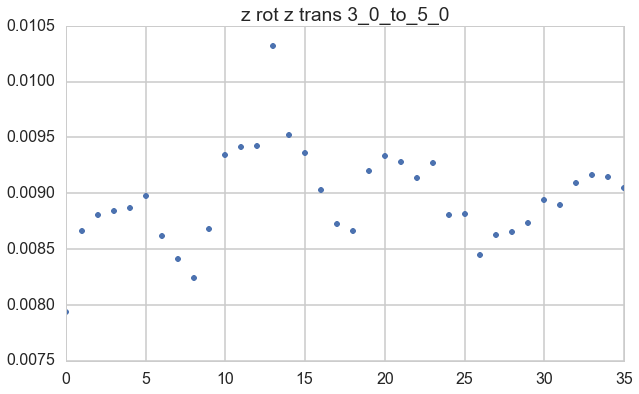

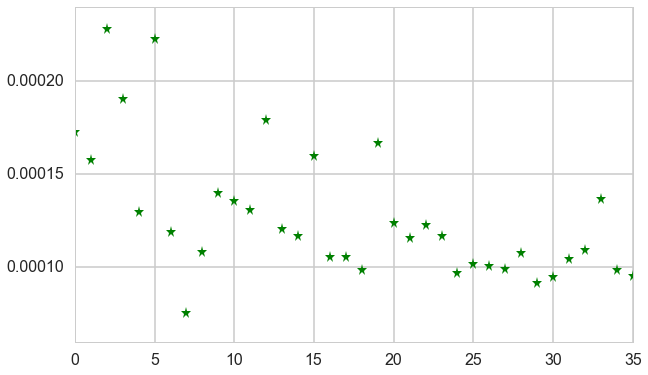

In [37]:
# plot results from 10mm
for i, rot_ax in enumerate(['x','y','z']):
    trans_ax = axes_dict[rot_ax]
    
    idx = 0
    residuals_10 = get_residuals_IRLS(cost_dict_10[i][2])
    e2_10 = get_residuals_IRLS(cost_dict_10[i][3])
    for rot_range in ranges:
        errors_to_plot = []
        e2_to_plot = []
        for rep in xrange(36):
            errors_to_plot.append(residuals_10[idx])
            e2_to_plot.append(e2_10[idx])
            idx += 1
        plt.figure(figsize=[10,6])
        plt.plot(errors_to_plot,'.')
        plt.title("%s rot %s trans %s" % (rot_ax, trans_ax, rot_range))
        plt.show()
        plt.figure(figsize=[10,6])
        plt.plot(e2_to_plot,'*',color='green')
        plt.show()

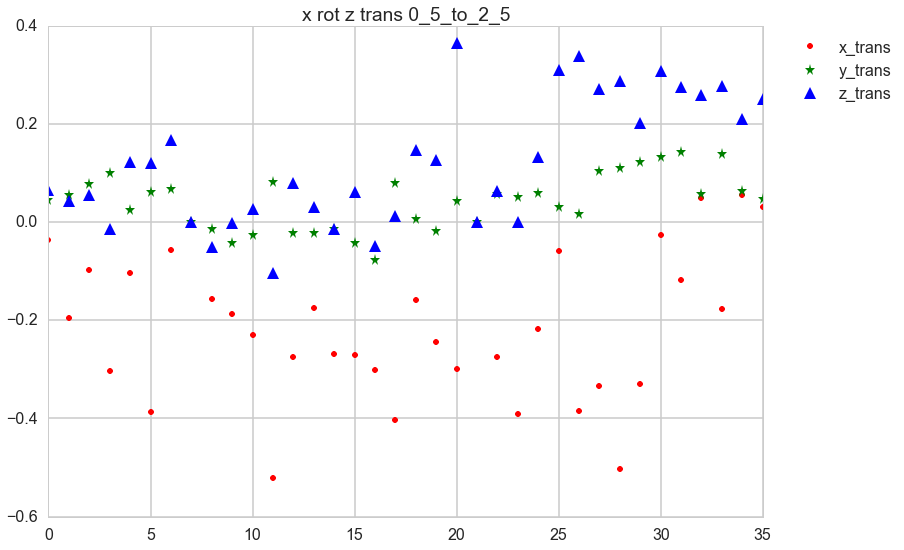

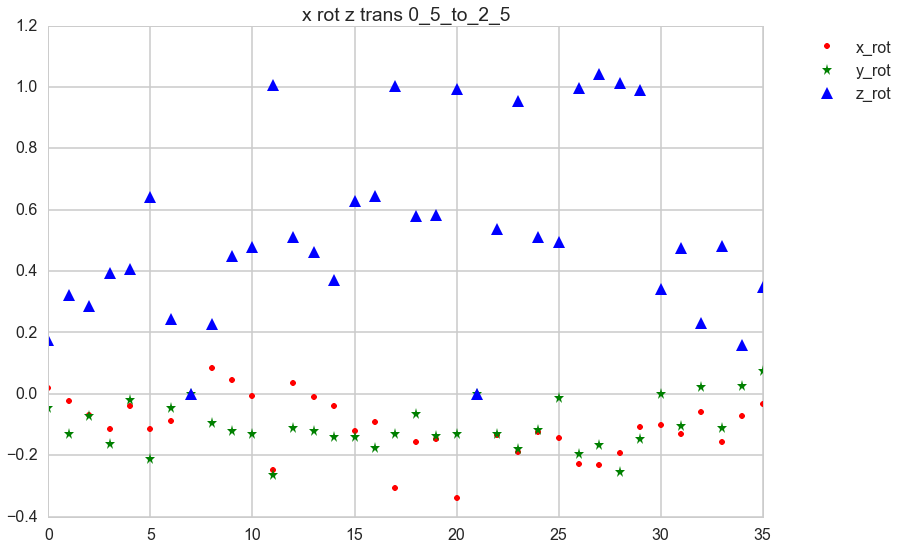

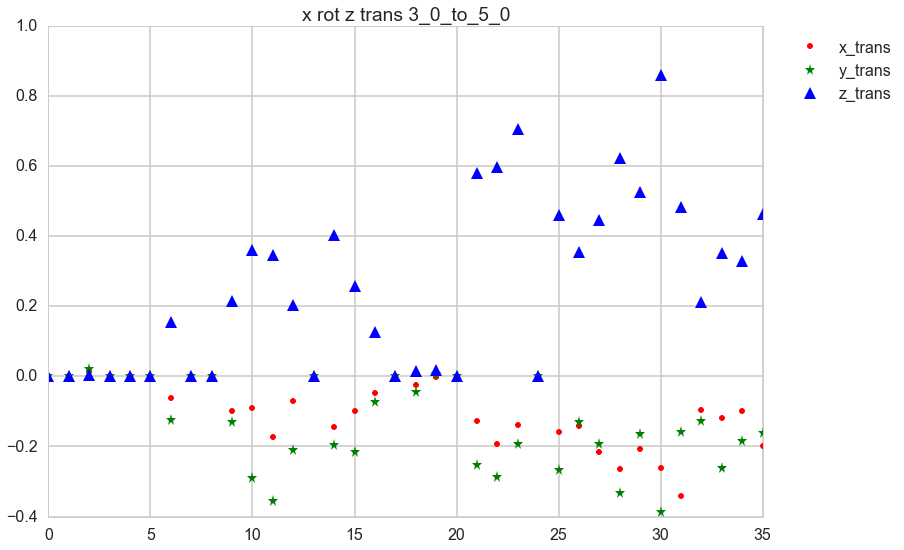

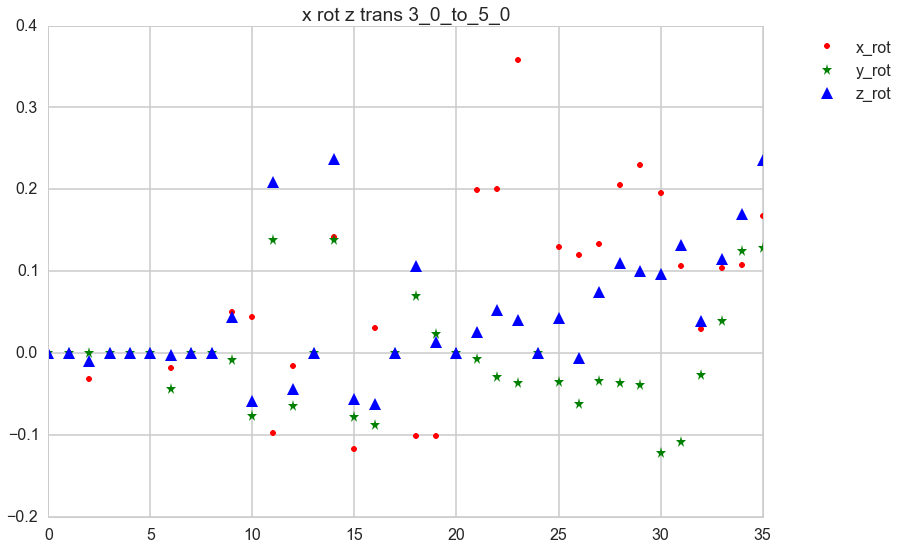

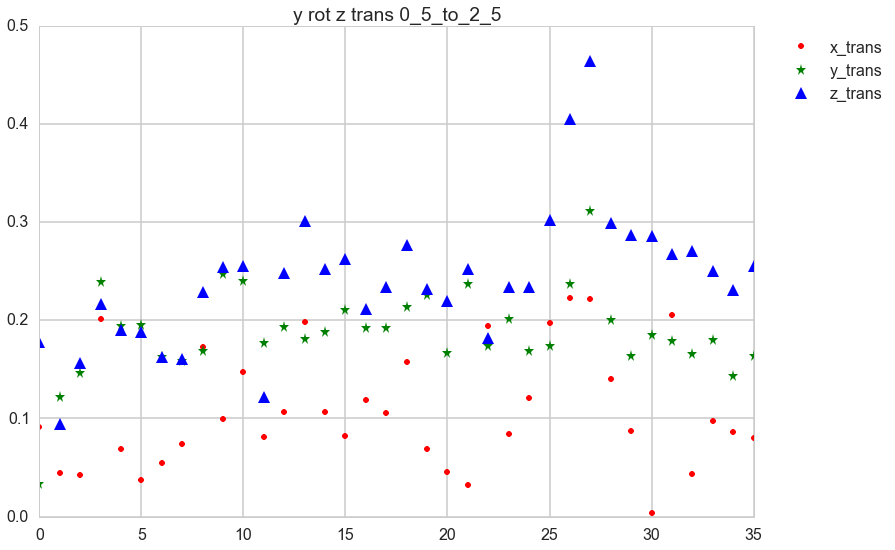

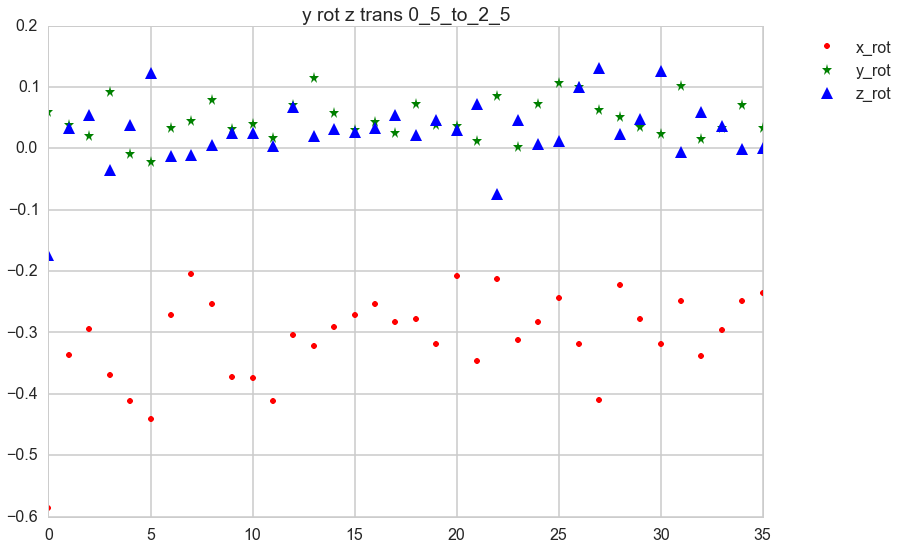

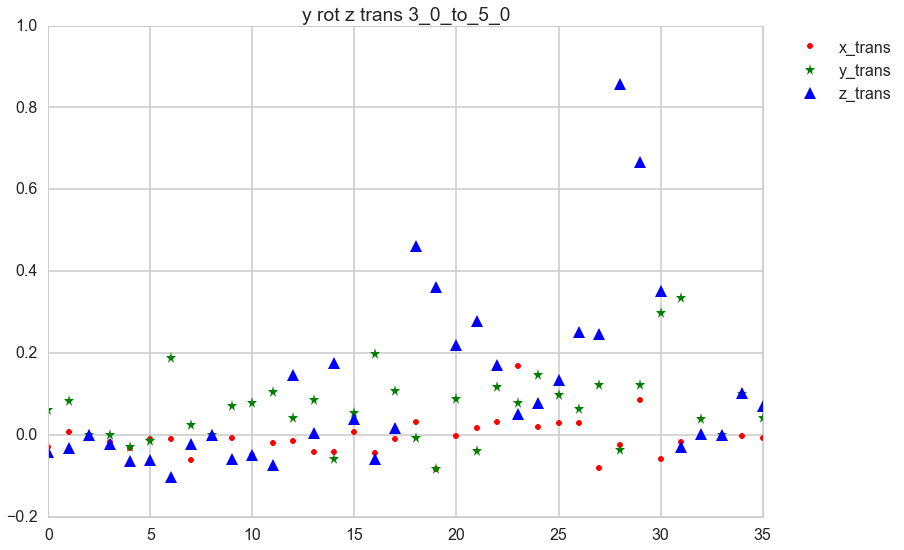

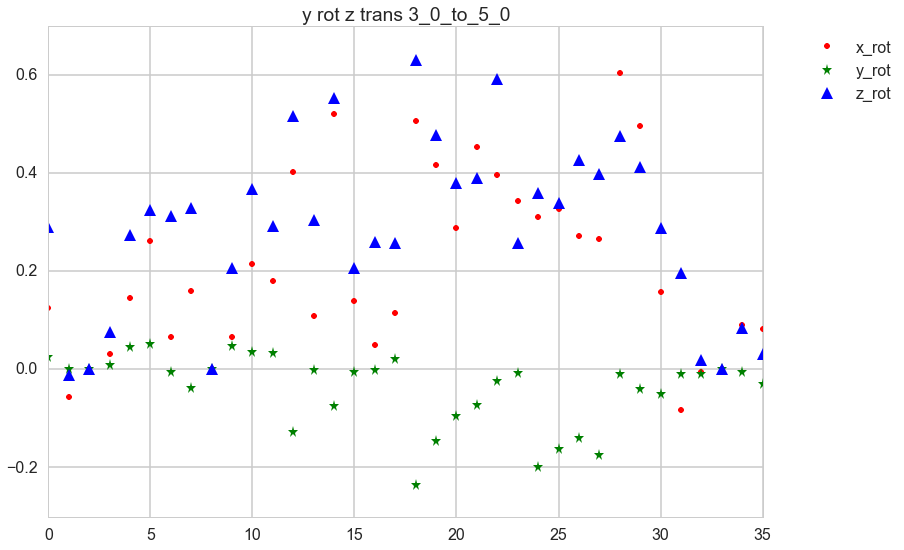

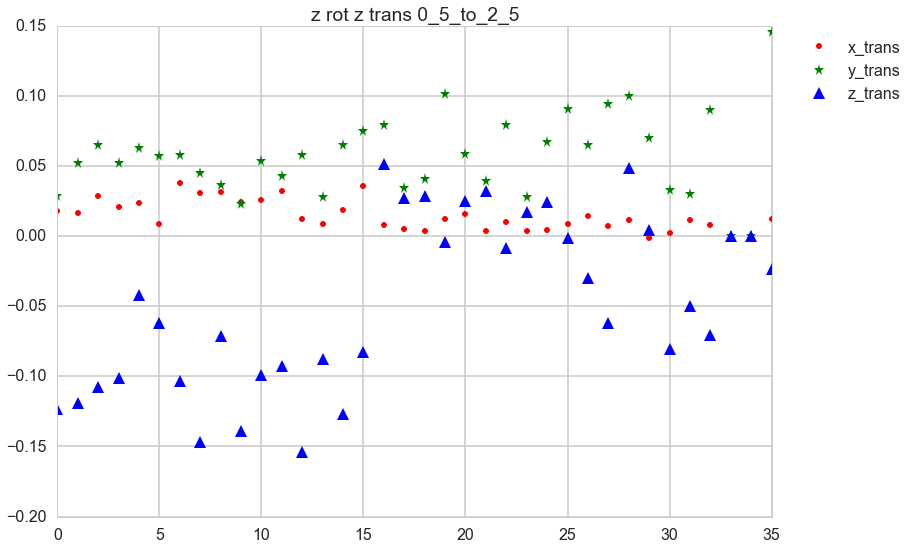

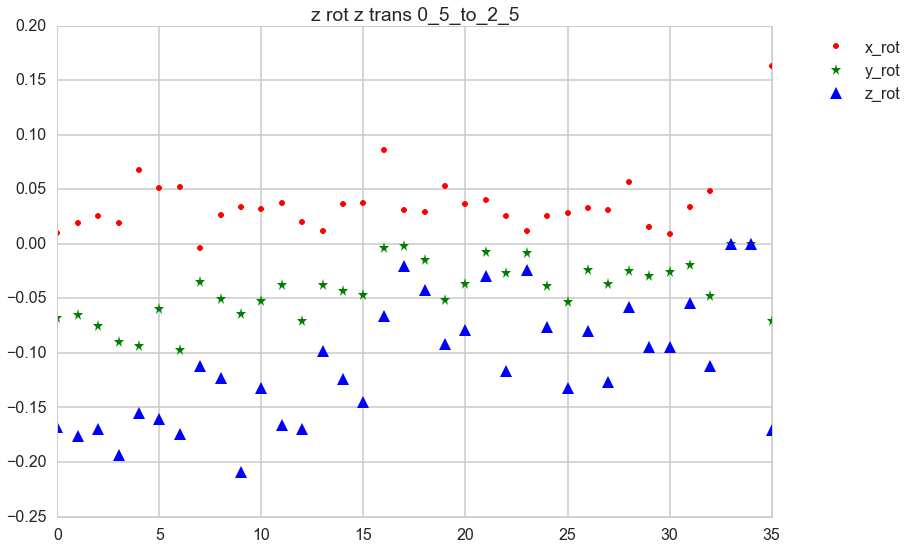

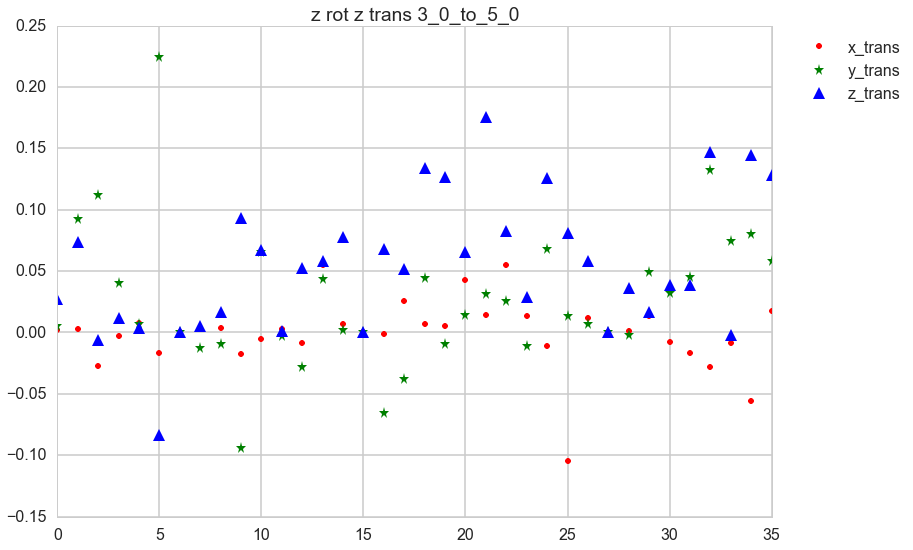

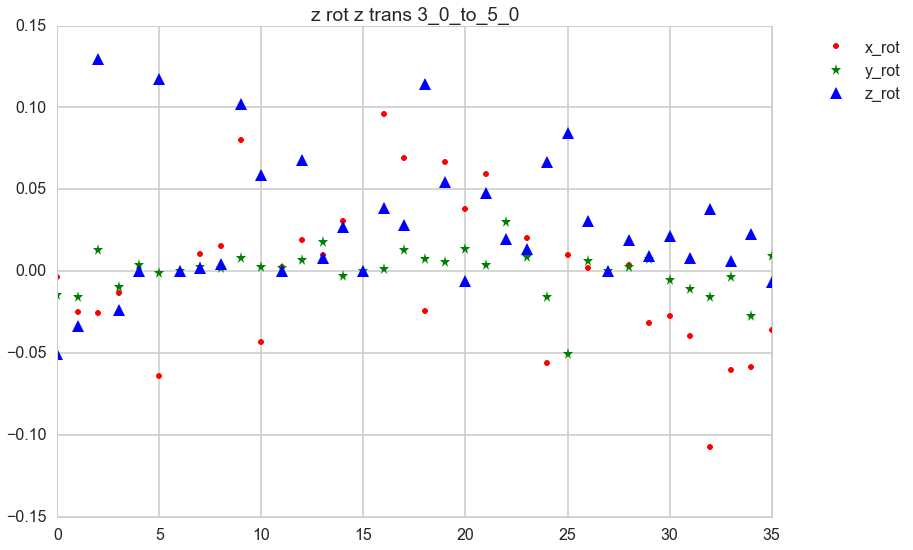

In [26]:
for i, rot_ax in enumerate(['x','y','z']):
    idx = 0
    trans_ax = axes_dict[rot_ax]
    ps_ls_10 = cost_dict_10[i][0]
    for rot_range in ranges:
        params_t = []
        params_r = []
        for rep in xrange(36):
            params_t.append(ps_ls_10[idx][-1][:3]*10)
            params_r.append(ps_ls_10[idx][-1][3:]*180/np.pi)
            idx += 1
        plt.plot(np.array(params_t)[:,0],'.',color='red',label='x_trans')
        plt.plot(np.array(params_t)[:,1],'*',color='green',label='y_trans')
        plt.plot(np.array(params_t)[:,2],'^',color='blue',label='z_trans')
        plt.title("%s rot %s trans %s" % (rot_ax, trans_ax, rot_range))
        plt.legend(bbox_to_anchor=(1.2, 1))
        plt.show()
        
        plt.plot(np.array(params_r)[:,0],'.',color='red',label='x_rot')
        plt.plot(np.array(params_r)[:,1],'*',color='green',label='y_rot')
        plt.plot(np.array(params_r)[:,2],'^',color='blue',label='z_rot')
        plt.title("%s rot %s trans %s" % (rot_ax, trans_ax, rot_range))
        plt.legend(bbox_to_anchor=(1.2, 1))
        plt.show()